This project will focus on using a series of Non-linear Optimization Models to Optimize the investment portfolios of both Nancy Pelosi and Pete Sessions.

In [ ]:
!pip install yfinance
!pip install --upgrade yfinance

# Trading Data Import

In [ ]:
import pandas as pd
import re
import yfinance as yf
import time
from google.colab import drive

drive.mount('/content/drive')

def create_portfolio_dataframe(file_path):
    # Load data from Google Drive
    df = pd.read_excel(file_path)

    # Convert date column to datetime
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    # Function to extract midpoint of amount range
    def get_midpoint(amount):
        numbers = list(map(int, re.findall(r'\d+', str(amount).replace(',', ''))))
        return sum(numbers) / 2 if numbers else None

    # Apply transformation
    df["Amount"] = df["Amount"].apply(get_midpoint)

    # Sort by date
    df = df.sort_values(by="Date")

    # Identify initial holdings: stocks that were only sold and never bought in the timeframe
    sold_stocks = df[df["Type"].str.contains("Sale")]["Ticker"].unique()
    bought_stocks = df[df["Type"].str.contains("Purchase")]["Ticker"].unique()
    initial_stocks = set(sold_stocks) - set(bought_stocks)

    initial_holdings = df[df["Ticker"].isin(initial_stocks) & df["Type"].str.contains("Sale")].copy()
    initial_holdings["Type"] = "Initial"
    initial_holdings["Date"] = pd.Timestamp("2023-12-31")

    # Combine initial holdings with original data
    df = pd.concat([initial_holdings, df]).sort_values(by="Date")

    # Function to get stock price at a given date
    def get_stock_price(ticker, date):
        try:
            formatted_ticker = ticker.replace("$", "").strip()  # Clean ticker symbols
            print(f"Fetching price for {formatted_ticker} on {date}")  # Debugging output
            stock = yf.Ticker(formatted_ticker)

            # Fetch price within a week of the target date to handle missing data
            historical_data = stock.history(period="1mo", start=(date - pd.Timedelta(days=3)).strftime("%Y-%m-%d"), end=(date + pd.Timedelta(days=3)).strftime("%Y-%m-%d"))

            if historical_data.empty:
                print(f"Warning: No price data found for {formatted_ticker} near {date}")
                return None

            # Get the closest available closing price
            return historical_data["Close"].iloc[-1]

        except Exception as e:
            print(f"Error fetching {formatted_ticker}: {e}")
            return None

    # Fetch stock prices once per row
    df["Stock Price"] = df.apply(lambda row: get_stock_price(row["Ticker"], row["Date"]), axis=1)

    # Calculate share count only when stock price is available
    df["Share Count"] = df.apply(
        lambda row: row["Amount"] / row["Stock Price"] if row["Stock Price"] and row["Amount"] else 0,
        axis=1
    )

    return df

# Example usage
nancy_df = create_portfolio_dataframe("/content/drive/My Drive/Banc-C - Stock Data.xlsx")
pete_df = create_portfolio_dataframe("/content/drive/My Drive/Pete Sessions.xlsx")
print(nancy_df)
print(pete_df)

Mounted at /content/drive
Fetching price for TSLA on 2023-12-31 00:00:00
Fetching price for V on 2023-12-31 00:00:00
Fetching price for MSFT on 2023-12-31 00:00:00
Fetching price for AAPL on 2023-12-31 00:00:00
Fetching price for PANW on 2024-02-12 00:00:00
Fetching price for PANW on 2024-02-21 00:00:00
Fetching price for AVGO on 2024-06-24 00:00:00
Fetching price for TSLA on 2024-06-24 00:00:00
Fetching price for NVDA on 2024-06-26 00:00:00
Fetching price for V on 2024-07-01 00:00:00
Fetching price for NVDA on 2024-07-26 00:00:00
Fetching price for MSFT on 2024-07-26 00:00:00
Fetching price for NVDA on 2024-12-20 00:00:00
Fetching price for PANW on 2024-12-20 00:00:00
Fetching price for AAPL on 2024-12-31 00:00:00
Fetching price for NVDA on 2024-12-31 00:00:00
Fetching price for GOOGL on 2025-01-14 00:00:00
Fetching price for AMZN on 2025-01-14 00:00:00
Fetching price for NVDA on 2025-01-14 00:00:00
Fetching price for TEM on 2025-01-14 00:00:00
Fetching price for VST on 2025-01-14 00:

The intial dataset is first imported.

# Get unique Tickers

In [ ]:
import pandas as pd

def get_unique_tickers(df):
    """
    Extracts a clean list of unique stock tickers from the given dataframe,
    removing any trailing spaces or special characters.

    Args:
        df (pd.DataFrame): The input dataframe containing a 'Ticker' column.

    Returns:
        list: A cleaned list of unique tickers.
    """
    return df['Ticker'].astype(str).str.strip().str.replace("\xa0", "", regex=True).unique().tolist()


In [ ]:
nancy_tickers = get_unique_tickers(nancy_df)
pete_tickers = get_unique_tickers(pete_df)

print(nancy_tickers)
print(pete_tickers)

['TSLA', 'V', 'MSFT', 'AAPL', 'PANW', 'AVGO', 'NVDA', 'GOOGL', 'AMZN', 'TEM', 'VST']
['CCI', 'AAPL', 'GIS', 'NVST', 'MO', 'COST', 'MSFT', 'V', 'NVDA', 'AMZN', 'GOOGL']


The above tickers are all the stocks that Nancy and Pete traded during the timeframe of the project (1/1/2024 - 1/14/2025).

In [ ]:
import yfinance as yf
import pandas as pd

def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetches historical adjusted closing prices for a list of stock tickers.

    Args:
        tickers (list): List of stock ticker symbols.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: DataFrame containing adjusted closing prices for all tickers.
    """
    df = pd.DataFrame()

    for ticker in tickers:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        # Check if 'Adj Close' column exists, if not, use 'Close'
        if 'Adj Close' in stock_data.columns:
            df[ticker] = stock_data['Adj Close']
        else:
            df[ticker] = stock_data['Close']

    df.index.name = "Date"
    return df

In [ ]:
nancy_stock_data = fetch_stock_data(nancy_tickers, '2024-01-01', '2025-01-14')
pete_stock_data = fetch_stock_data(pete_tickers, '2024-01-01', '2025-01-14')

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

In [ ]:
# prompt: drop VST from nancy_stock data

# Drop VST from nancy_stock_data
if 'VST' in nancy_stock_data.columns:
    nancy_stock_data = nancy_stock_data.drop(columns=['VST'])
#Drop COST from pete_stock_data
if 'COST' in pete_stock_data.columns:
    pete_stock_data = pete_stock_data.drop(columns=['COST'])


VST (Nancy) and COST (Pete) was excluded to focus solely on the top 10 stocks with the highest trading volumes, as it ranked lowest in trade activity among the group which was discovered in the EDA section of this project.

# Final Dataset

In [ ]:
pete_stock_data.head()

,CCI,AAPL,GIS,NVST,MO,MSFT,V,NVDA,AMZN,GOOGL
Date,,,,,,,,,,
2024-01-02,109.903191,184.532074,63.780903,24.100000,38.290985,367.380585,256.474701,48.154346,149.929993,137.670929
2024-01-03,106.953461,183.150375,63.761806,23.459999,38.125221,367.113159,255.592987,47.555515,148.470001,138.418228
2024-01-04,107.434090,180.824341,62.815830,23.379999,38.235729,364.478180,257.207855,47.984398,144.570007,135.897354
2024-01-05,107.217323,180.098694,62.099186,23.379999,38.208107,364.289978,257.287170,49.083080,145.240005,135.239746
2024-01-08,108.150314,184.452560,61.764763,24.030001,38.594879,371.164673,260.110809,52.238186,149.100006,138.338516


In [ ]:
nancy_stock_data.tail(10)

,TSLA,V,MSFT,AAPL,PANW,AVGO,NVDA,GOOGL,AMZN,TEM
Date,,,,,,,,,,
2024-12-27,431.660004,318.124695,429.668457,255.309296,186.179993,241.750000,137.009995,192.759995,223.750000,35.119999
2024-12-30,417.410004,314.780334,423.979858,251.923019,184.199997,235.580002,137.490005,191.240005,221.300003,33.869999
2024-12-31,403.839996,315.509125,420.656525,250.144974,181.960007,231.839996,134.289993,189.300003,219.389999,33.759998
2025-01-02,379.279999,313.871857,417.742371,243.582199,180.740005,231.979996,138.309998,189.429993,220.220001,34.250000
2025-01-03,410.440002,314.381012,422.502838,243.092728,183.250000,232.550003,144.470001,191.789993,224.190002,38.250000
2025-01-06,411.049988,312.514160,426.993835,244.730927,179.500000,236.410004,149.429993,196.869995,227.610001,40.759998
2025-01-07,394.359985,311.146454,421.524780,241.944000,175.509995,228.639999,140.139999,195.490005,222.110001,38.875000
2025-01-08,394.940002,312.074890,423.710419,242.433441,172.830002,229.309998,140.110001,193.949997,222.130005,37.490002
2025-01-10,394.739990,307.193085,418.111633,236.589874,173.419998,224.309998,135.910004,192.039993,218.940002,37.520000


The above is the final dataset that will be used for Nancy and Pete's portfolio construction.

# Import Ipopt

In [ ]:
from pyomo.environ import *

# Calculating the Mean Returns of Nancy and Pete's Portfolio

In [ ]:
pete_stock_data_return = pete_stock_data.mean()

In [ ]:
nancy_stock_data_return = nancy_stock_data.mean()

Here we calculated what is gone be the average return for each stock based on the dataset for Nancy Pelosi and Pete Sessions.

In [ ]:
nancy_stock_data_return

,0
TSLA,235.147066
V,279.763645
MSFT,417.990826
AAPL,207.472383
PANW,166.567027
AVGO,153.800296
NVDA,108.685690
GOOGL,164.211435
AMZN,185.637413
TEM,46.363069


Here's a more detailed breakdown of the mean return for each stock, including the company name and sector:  

| **Ticker** | **Company Name**            | **Sector**                | **Mean Return** |
|------------|-----------------------------|---------------------------|-----------------|
| TSLA       | Tesla Inc.                  | Consumer Discretionary    | **235.15**      |
| V          | Visa Inc.                   | Financials                | **279.76**      |
| MSFT       | Microsoft Corporation       | Technology                | **417.99**      |
| AAPL       | Apple Inc.                  | Technology                | **207.47**      |
| PANW       | Palo Alto Networks Inc.     | Technology                | **166.57**      |
| AVGO       | Broadcom Inc.               | Technology                | **153.80**      |
| NVDA       | NVIDIA Corporation          | Technology                | **108.69**      |
| GOOGL      | Alphabet Inc.               | Communication Services    | **164.21**      |
| AMZN       | Amazon.com Inc.             | Consumer Discretionary    | **185.64**      |
| TEM        | Temenos AG                  | Technology                | **46.36**    

1. Top Performer: Microsoft (MSFT) leads the pack with an outstanding mean return of 417.99.

2. Innovation in Motion: Tesla (TSLA) makes a strong impression in consumer discretionary with a mean return of 235.15, reflecting its dynamic market presence.

3. Tech Sector Powerhouse: A cluster of technology giants including Apple (AAPL), Microsoft (MSFT), NVIDIA (NVDA), Palo Alto Networks (PANW), Broadcom (AVGO), and Temenos (TEM) underscores the sector’s dominance.

4. Financial Resilience: Visa (V) stands out in the financial arena with a robust mean return of 279.76.

5. Digital Pioneers: Alphabet (GOOGL) and Amazon (AMZN) represent the digital and consumer segments, delivering mean returns of 164.21 and 185.64 respectively.

6. Lowest Mean Return: Temenos (TEM) records the smallest mean return at 46.36, which may suggest a more cautious market approach or opportunities for future growth.

In [ ]:
pete_stock_data_return

,0
CCI,101.526324
AAPL,207.472384
GIS,65.842680
NVST,19.640618
MO,45.588572
MSFT,417.990827
V,279.763644
NVDA,108.685690
AMZN,185.637413
GOOGL,164.211436


Here's a more detailed breakdown of the mean return for each stock, including the company name and sector:  

| **Ticker** | **Company Name**            | **Sector**                | **Mean Return** |
|-----------|-----------------------------|---------------------------|---------------|
| CCI       | Crown Castle Inc.      | Real Estate              | **101.53**   |
| AAPL      | Apple Inc.            | Technology               | **207.47**   |
| GIS       | General Mills Inc.     | Consumer Staples         | **65.84**    |
| NVST      | Envista Holdings       | Healthcare               | **19.64**    |
| MO        | Altria Group Inc.      | Consumer Staples         | **45.59**    |
| MSFT      | Microsoft Corporation  | Technology               | **417.99**   |
| V         | Visa Inc.              | Financials               | **279.76**   |
| NVDA      | NVIDIA Corporation     | Technology               | **108.69**   |
| AMZN      | Amazon.com Inc.       | Consumer Discretionary   | **185.64**   |
| GOOGL     | Alphabet Inc.          | Communication Services   | **164.21**   |

1. Top Performer: Microsoft (MSFT) with 417.99 mean return.
2. Tech Sector Dominance: Apple (AAPL), Microsoft (MSFT), and NVIDIA (NVDA) lead the list.
3. Financial Strength: Visa (V) has a strong mean return of 279.76.
4. Consumer Staples Stability: General Mills (GIS) and Altria (MO) show moderate returns, aligning with their defensive nature.
5. Real Estate Performance: Crown Castle (CCI), a major REIT, shows a solid return of 101.53.
6. Smallest Mean Return: Envista Holdings (NVST)at 19.64, potentially indicating lower volatility or lower growth.

# Covariance

In [ ]:
nancy_stock_data_cov = nancy_stock_data.cov()

In [ ]:
pete_stock_data_cov = pete_stock_data.cov()

Here we calculate the Covariance of the stocks.

- Covariance is a statistical measure that shows the relationship between two variables, specifically how they move together. In the case of stocks, covariance helps determine whether two stocks move in the same direction or in opposite directions over time.

- Covariance is useful in portfolio management and risk assessment because it helps in understanding the relationship between stocks:

1. Identifying Diversification Benefits  
   - If covariance is positive, the two stocks move together (i.e., when one increases, the other tends to increase).  
   - If covariance is negative, the stocks move in opposite directions (i.e., one increases while the other decreases).  
   - If covariance is close to zero, the stocks are largely unrelated in movement.

2. Portfolio Risk Reduction  
   - If a portfolio consists of stocks with negative or low covariance, it is better diversified and experiences less overall risk.  
   - A mix of assets that do not move together reduces the impact of market fluctuations.

3. Understanding Market Trends  
   - A high positive covariance suggests the stocks react similarly to market conditions, which may be risky if the market declines.
   - A negative covariance can be beneficial as losses in one stock might be offset by gains in another.

In [ ]:
!pip install --upgrade seaborn


## Pete Covariance Matrix

In [ ]:
pete_stock_data_cov

,CCI,AAPL,GIS,NVST,MO,COST,MSFT,V,NVDA,AMZN,GOOGL
CCI,53.220832,39.127996,13.004482,0.645206,10.660535,96.256682,-29.564035,-20.630340,6.536517,-45.819959,-47.958681
AAPL,39.127996,673.510894,10.876286,-25.310408,135.855469,2189.064414,250.146786,225.146729,585.717598,318.263118,291.075059
GIS,13.004482,10.876286,12.687761,-2.811864,7.239864,82.715327,-0.016439,-5.526614,20.420041,-2.391289,-1.260893
NVST,0.645206,-25.310408,-2.811864,5.071327,-5.702409,-104.267953,-23.257614,6.062452,-35.893657,-12.827020,-21.408567
MO,10.660535,135.855469,7.239864,-5.702409,35.104347,514.256149,46.223953,60.030803,139.704804,75.466927,61.053053
COST,96.256682,2189.064414,82.715327,-104.267953,514.256149,8548.999122,1038.894996,971.510796,2338.703859,1327.769426,1072.179067
MSFT,-29.564035,250.146786,-0.016439,-23.257614,46.223953,1038.894996,320.235288,91.935724,331.840530,225.270380,205.275141
V,-20.630340,225.146729,-5.526614,6.062452,60.030803,971.510796,91.935724,279.463011,244.851505,243.862017,113.584534
NVDA,6.536517,585.717598,20.420041,-35.893657,139.704804,2338.703859,331.840530,244.851505,735.577992,384.780816,335.242427
AMZN,-45.819959,318.263118,-2.391289,-12.827020,75.466927,1327.769426,225.270380,243.862017,384.780816,332.489118,231.781610


Key Observations from the Covariance Matrix  

1. Strong Positive Covariance – Stocks Moving Together  
A high positive covariance suggests these stocks tend to increase or decrease together, which is crucial for portfolio diversification:  
- AAPL & NVDA (585.72) → Very strong correlation (likely due to their tech industry connection).  
- MSFT & NVDA (331.84) → Moves together significantly.   

2. Strong Negative Covariance – Stocks Moving Oppositely  
A negative covariance suggests that one stock increases when the other decreases, which can be beneficial for diversification:  
- AMZN & CCI (-45.82) → Amazon and Crown Castle show opposing trends, possibly due to sector differences.  
- GOOGL & CCI (-47.96) → Google and Crown Castle are negatively correlated.  

3. Diversification Insights  
- If an investor holds a portfolio of highly correlated stocks (e.g., AAPL, NVDA, MSFT), the portfolio will have high volatility.  
- Adding negatively correlated stocks (e.g., CCI, GIS, NVST) could help reduce risk through diversification.  
- NVST, GIS, and MO have lower correlations with tech stocks, making them potential hedge options.  


## Nancy Covariance Matrix

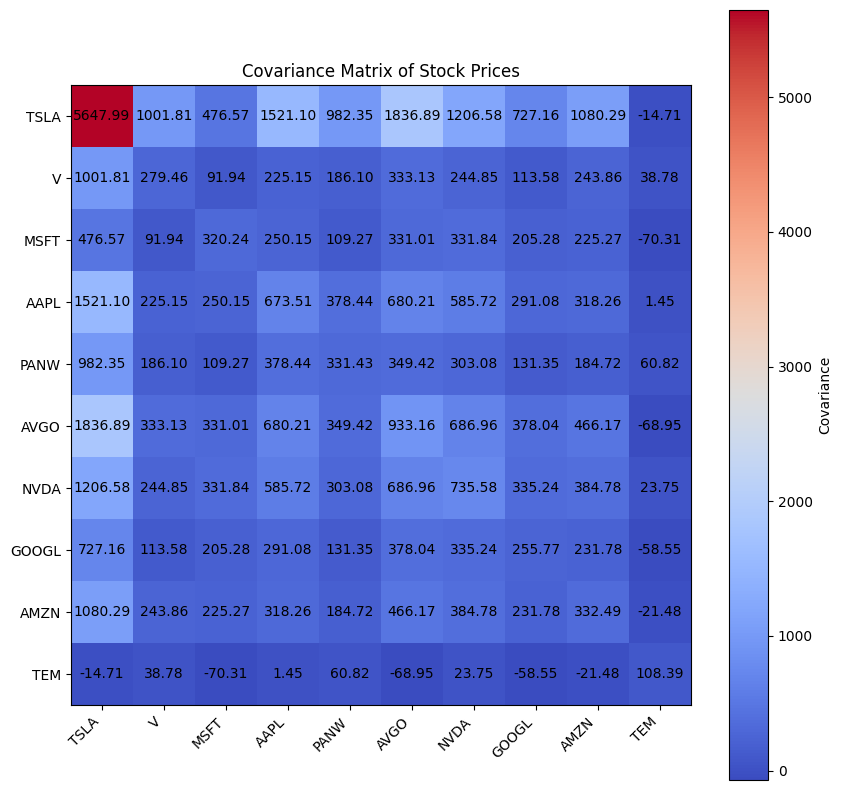

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
plt.imshow(nancy_stock_data_cov, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Covariance')
plt.xticks(np.arange(len(nancy_stock_data_cov.columns)), nancy_stock_data_cov.columns, rotation=45, ha='right')
plt.yticks(np.arange(len(nancy_stock_data_cov.index)), nancy_stock_data_cov.index)

# Annotate the heatmap with covariance values
for i in range(len(nancy_stock_data_cov.index)):
    for j in range(len(nancy_stock_data_cov.columns)):
        plt.text(j, i, f'{nancy_stock_data_cov.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Covariance Matrix of Stock Prices')
plt.show()


Key Observations from the Covariance Matrix

1. Strong Positive Covariance – Stocks Moving Together  
   A high positive covariance indicates these stocks tend to move in the same direction, magnifying gains or losses when held together:  
   - AVGO & TSLA (1836.89) → One of the highest positive covariances, suggesting these two are highly synchronized in their movements.  
   - TSLA & AAPL (1521.10) → Another significant pairing, indicating Tesla and Apple often rise or fall in tandem.

3. Strong Negative Covariance – Stocks Moving in Opposite Directions  
   A negative covariance suggests that when one stock’s returns increase, the other’s tend to decrease, offering potential risk mitigation:  
   - MSFT & TEM (-70.31) → Notable negative relationship, which may help stabilize a portfolio if both are held.  
   - AVGO & TEM (-68.95) → Similarly inverse correlation, providing diversification benefits for investors exposed to AVGO’s volatility.

4. Diversification Insights  
   - High positive covariances (e.g., AVGO & TSLA, TSLA & AAPL) can lead to increased portfolio volatility if these stocks are grouped together.  
   - Negative correlations (e.g., MSFT & TEM, AVGO & TEM) are valuable for reducing overall risk, as losses in one position could be offset by gains in the other.  
   - Combining positively correlated growth stocks (TSLA, AAPL, AVGO) with negatively correlated assets (TEM) can help balance a portfolio and moderate swings.

Conclusion  
- Investors should be mindful of highly correlated pairs like AVGO & TSLA and TSLA & AAPL, as they amplify risk when held simultaneously.  
- MSFT & TEM and AVGO & TEM offer potential hedge opportunities due to their negative covariance.  
- A strategic mix of these stocks could enhance diversification by balancing high-growth, high-volatility positions with more defensive, inversely correlated holdings.

In [ ]:
# prompt: NameError: name 'ConcreteModel' is not defined

!pip install pyomo
!apt-get install -y -qq glpk-utils


Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
m = ConcreteModel()

# Nancy Pelosi Stock Portfolio Allocation

# Decision Variables

These are the decision variables we will use to build the non-linear optimization model for Nancy's Sessions, aimed at maximizing return and minimizing risk:

1. APPL
2. MSFT
3. GOOGL
4. TSLA
5. V
6. PANW
7. AVGO
8. NVDA
9. AMZN
10. TEM


In [ ]:
# Add new tickers to the objective function
m.AAPL = Var(domain=NonNegativeReals, bounds=(0, 1))
m.MSFT = Var(domain=NonNegativeReals, bounds=(0, 1))
m.GOOGL = Var(domain=NonNegativeReals, bounds=(0, 1))
m.TSLA = Var(domain=NonNegativeReals, bounds=(0, 1))
m.V = Var(domain=NonNegativeReals, bounds=(0, 1))
m.PANW = Var(domain=NonNegativeReals, bounds=(0, 1))
m.AVGO = Var(domain=NonNegativeReals, bounds=(0, 1))
m.NVDA = Var(domain=NonNegativeReals, bounds=(0, 1))
m.AMZN = Var(domain=NonNegativeReals, bounds=(0, 1))
m.TEM = Var(domain=NonNegativeReals, bounds=(0, 1))

This block of code is defining decision variables for a non-linear optimization model. Each variable represents the proportion or allocation of an asset (stock) in the portfolio. Here's a detailed breakdown:

**Explanation of Each Line:**
1. m.AAPL = Var(domain=NonNegativeReals, bounds=(0, 1))
   - m.AAPL: This is a decision variable representing the proportion allocated to Apple (AAPL) in the portfolio.
   - domain=NonNegativeReals: This means the variable must be a non-negative real number (i.e., no negative values, such as -0.5).
   - bounds=(0, 1): The variable is bounded between 0 and 1, meaning the allocation to AAPL can range from 0 (no investment) to 1 (fully invested in AAPL). Any fractional value like 0.1, 0.5, 0.9, etc., is allowed within this range.
   
Each of these variables (m.AVGO, m.AAPL, m.TEM, etc.) will be part of the optimization model. These variables will represent the fraction of the total portfolio allocated to each respective stock.

# Objective Function - MAX (Return)

In [ ]:
# Update the objective function to include the new tickers
# Assuming nancy_stock_data_return contains the returns for all tickers
m.objective = Objective(expr = m.AAPL * nancy_stock_data_return['AAPL'] +
                        m.MSFT * nancy_stock_data_return['MSFT'] +
                        m.GOOGL * nancy_stock_data_return['GOOGL'] +
                        m.TSLA * nancy_stock_data_return['TSLA'] +
                        m.V * nancy_stock_data_return['V'] +
                        m.PANW * nancy_stock_data_return['PANW'] +
                        m.AVGO * nancy_stock_data_return['AVGO'] +
                        m.NVDA * nancy_stock_data_return['NVDA'] +
                        m.AMZN * nancy_stock_data_return['AMZN'] +
                        m.TEM * nancy_stock_data_return['TEM'], sense=maximize)


This line of code defines the objective function for your optimization model, which aims to **maximize** the return of the portfolio by allocating investments across various stocks.

- m.Objective:  
  This creates an objective function named Objective in the optimization model m. The goal of this function is to be maximized, meaning the optimization process will attempt to maximize the expression defined within expr.

- The optimization model will adjust the allocations (m.TSLA, m.AAPL, etc.) within the bounds specified earlier (0 to 1) to maximize the total return.


#Baseline (5% Risk - 1% Return)

The risk and return levels chosen for this scenario is meant to reflect an average person's investment profile. If Nancy was bearish in terms of risk levels, and just willing to accept minimum returns and stay conservative.

## Setting Up the Constraints

In [ ]:
# Update constraints to include new tickers
m.total_risk = Constraint(expr = m.AAPL + m.MSFT + m.GOOGL + m.TSLA + m.V + m.PANW + m.AVGO + m.NVDA + m.AMZN + m.TEM <= 0.05)
m.sum_proportion = Constraint(expr = m.AAPL + m.MSFT + m.GOOGL + m.TSLA + m.V + m.PANW + m.AVGO + m.NVDA + m.AMZN + m.TEM == 1)
m.return_floor = Constraint(expr = m.objective >= 0.01) # min return = 1%

The constraints in the optimization model are designed to achieve a well-balanced portfolio while adhering to key investment guidelines.

- The total risk constraint ensures that the combined risk of all assets in the portfolio does not exceed 5%, thus limiting the overall exposure to volatility or uncertainty.

- The sum of proportions constraint encourages optimal capital utilization.

- Additionally, the return floor constraint sets a minimum required return of 1%, ensuring that the model only considers portfolios that meet or exceed this threshold.

Together, these constraints help optimize the portfolio by balancing risk, return, and full utilization of the available capital.

## Computing Portfolio's Variance (Risk)

In [ ]:
# prompt: expr_risk = calc_risk(m)
# IndexError: index 10 is out of bounds for axis 0 with size 10

# Update the variables list and tickers list in calc_risk function
def calc_risk(m):
    variables = [m.AAPL, m.MSFT, m.GOOGL, m.TSLA, m.V, m.PANW, m.AVGO, m.NVDA, m.AMZN, m.TEM]
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'V', 'PANW', 'AVGO', 'NVDA', 'AMZN', 'TEM']
    risk_exp = 0
    for i in range(len(variables)):
        for j in range(len(variables)):
            try:
                risk_exp += variables[i] * variables[j] * nancy_stock_data_cov.iloc[i, j]
            except IndexError:
                print(f"IndexError: i={i}, j={j}")
                # Handle the IndexError appropriately, e.g., skip the problematic indices
                # or assign a default value to risk_exp.
                continue # skip this pair of indices
    return risk_exp
expr_risk = calc_risk(m)


In [ ]:
max_risk = 0.05

This is in line with the risk constraint we set at 5%.

In [ ]:
import numpy as np

risk_limits = np.arange(0.0003, max_risk, 0.0005)
risk_limits

array([0.0003, 0.0008, 0.0013, 0.0018, 0.0023, 0.0028, 0.0033, 0.0038,
       0.0043, 0.0048, 0.0053, 0.0058, 0.0063, 0.0068, 0.0073, 0.0078,
       0.0083, 0.0088, 0.0093, 0.0098, 0.0103, 0.0108, 0.0113, 0.0118,
       0.0123, 0.0128, 0.0133, 0.0138, 0.0143, 0.0148, 0.0153, 0.0158,
       0.0163, 0.0168, 0.0173, 0.0178, 0.0183, 0.0188, 0.0193, 0.0198,
       0.0203, 0.0208, 0.0213, 0.0218, 0.0223, 0.0228, 0.0233, 0.0238,
       0.0243, 0.0248, 0.0253, 0.0258, 0.0263, 0.0268, 0.0273, 0.0278,
       0.0283, 0.0288, 0.0293, 0.0298, 0.0303, 0.0308, 0.0313, 0.0318,
       0.0323, 0.0328, 0.0333, 0.0338, 0.0343, 0.0348, 0.0353, 0.0358,
       0.0363, 0.0368, 0.0373, 0.0378, 0.0383, 0.0388, 0.0393, 0.0398,
       0.0403, 0.0408, 0.0413, 0.0418, 0.0423, 0.0428, 0.0433, 0.0438,
       0.0443, 0.0448, 0.0453, 0.0458, 0.0463, 0.0468, 0.0473, 0.0478,
       0.0483, 0.0488, 0.0493, 0.0498])

In [ ]:
!pip install pyomo
!pip install ipopt
from pyomo.environ import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for ipopt
  Running setup.py clean for ipopt
Failed to build ipopt
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (ipopt)


In [ ]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 63.6MB/s]


## Calculating Iterations of Different Risk Limits

In [ ]:
param_analysis = {}
returns = {}
for r in risk_limits:
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()
  param_analysis[r] = [m.AAPL(), m.MSFT(), m.GOOGL(), m.TSLA(), m.V(), m.PANW(), m.AVGO(), m.NVDA(), m.AMZN(), m.TEM()]
  returns[r] =  m.AAPL()*nancy_stock_data_return['AAPL'] + m.MSFT()*nancy_stock_data_return['MSFT'] + m.GOOGL()*nancy_stock_data_return['GOOGL'] + m.TSLA()*nancy_stock_data_return['TSLA'] + m.V()*nancy_stock_data_return['V'] + m.PANW()*nancy_stock_data_return['PANW'] + m.AVGO()*nancy_stock_data_return['AVGO'] + m.NVDA()*nancy_stock_data_return['NVDA'] + m.AMZN()*nancy_stock_data_return['AMZN'] + m.TEM()*nancy_stock_data_return['TEM']

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.17940378189086914
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 2.267383337020874
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 2.2927463054656982
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 2.147914409637451
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.29410791397094727
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 2.039517879486084
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 3.284842014312744
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 4.3063554763793945
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.41793012619018555
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.20994925498962402
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.7952678203582764
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.151573657989502
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1855545043945312
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2451629638671875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.320906162261963
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.5938327312469482
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.5131230354309082
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.0607144832611084
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06449651718139648
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.3813204765319824
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09021353721618652
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07271599769592285
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.030238389968872
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2676324844360352
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1464099884033203
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2576730251312256
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2073919773101807
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.4518678188323975
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2813293933868408
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.0414271354675293
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.17299985885620117
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.7140462398529053
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.4047038555145264
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.296083688735962
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1518633365631104
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2588555812835693
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2858622074127197
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2184574604034424
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2613348960876465
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2739832401275635
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.5907139778137207
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.5919477939605713
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2064192295074463
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2081248760223389
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09788656234741211
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.0496575832366943
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2503752708435059
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2281408309936523
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2873544692993164
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08808612823486328
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.47974395751953125
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.182175874710083
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.6657629013061523
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.12291431427001953
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.16999530792236328
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.34523439407348633
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.622814416885376
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3497488498687744
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07460999488830566
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2384693622589111
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.250734806060791
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1915576457977295
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2443218231201172
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.389857292175293
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.161301612854004
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.20918536186218262
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 1.2260479927062988
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.5937798023223877
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2415673732757568
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08930110931396484
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06659054756164551
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.4101734161376953
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.14232444763183594
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1610879898071289
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.5565774440765381
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.262772798538208
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1798195838928223
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2310376167297363
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08862733840942383
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2609319686889648
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.6953904628753662
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.9150364398956299
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.167726755142212
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06198382377624512
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2452340126037598
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.15224146842956543
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2646064758300781
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09663772583007812
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3533663749694824
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2547941207885742
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2481379508972168
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2497384548187256
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2863690853118896
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.508014440536499
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.601731538772583
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2310330867767334
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1795682907104492
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09281563758850098
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1443111896514893
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2594518661499023
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

## Optimal Stock Allocation for Different Risk Levels

<Figure size 1200x600 with 0 Axes>

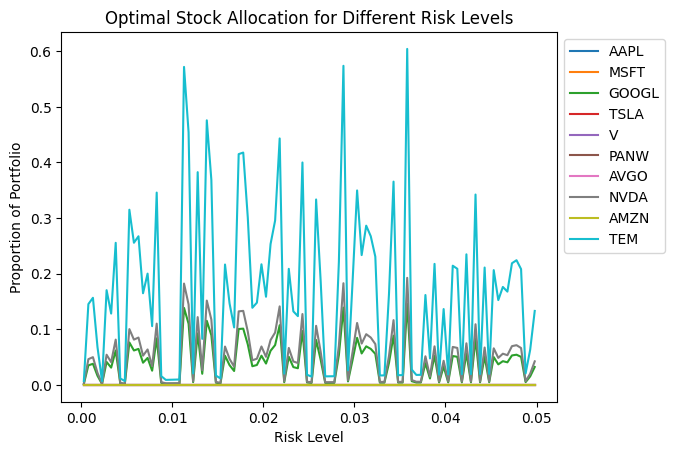

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming param_analysis is already defined
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'V', 'PANW', 'AVGO', 'NVDA', 'AMZN', 'TEM']

plt.figure(figsize=(12, 6))  # Adjust figure size
param_analysis.plot()

plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Proportion of Portfolio')

# Move legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


The stock allocations at every risk level were consistent, including that of 5% risk.

1. Single-Stock Dominance  
   - The most striking observation is that TEM consistently holds the majority allocation across all risk levels. Its share dwarfs those of NVDA and GOOGL, indicating the model strongly favors TEM as the primary driver of portfolio returns (or risk mitigation).

2. Supporting Allocations: NVDA and GOOGL  
   - NVDA and GOOGL appear at similar, lower allocation levels compared to TEM.  
   - Their allocations vary slightly, but they never approach TEM’s dominant share, suggesting the optimization algorithm views NVDA and GOOGL as secondary or complementary holdings rather than core components.

3. Minimal Diversification  
   - Only three stocks—TEM, NVDA, and GOOGL—are represented in the portfolio.  
   - With TEM overwhelmingly in the lead, the portfolio is highly concentrated in a single position.  
   - This limited stock selection raises questions about sector risk and overall diversification benefits, since the portfolio lacks exposure to other asset classes or industries. To add on that, their covariance values were relatively high as well based on the matrix.

4. Risk Level Sensitivity  
   - The chart does not show dramatic shifts in allocation as risk tolerance changes; TEM remains the dominant holding throughout.  
   - This suggests the model’s solution is relatively insensitive to varying levels of risk, or it perceives TEM as the most efficient choice under both conservative and aggressive scenarios.

In [ ]:
# prompt: Reward of portfolio at 5%

# Assuming 'param_analysis' DataFrame and 'returns' dictionary are already created as in the provided code.

# Access the row corresponding to a 5% risk level (or the closest available value).
risk_level_5_percent = 0.05  # Or find the closest value in risk_limits

# Check if 5% risk is exactly in the index. If not use .loc to handle potential KeyError
if risk_level_5_percent in param_analysis.index:
  portfolio_at_5_percent = param_analysis.loc[risk_level_5_percent]
  reward_at_5_percent = returns[risk_level_5_percent]
else:
    # Find the closest risk level to 5%
    closest_risk_level = min(param_analysis.index, key=lambda x: abs(x - risk_level_5_percent))
    portfolio_at_5_percent = param_analysis.loc[closest_risk_level]
    reward_at_5_percent = returns[closest_risk_level]

print(f"Stock proportions at or near 5% risk level:\n{portfolio_at_5_percent}")
print(f"\nReward at or near 5% risk level: {reward_at_5_percent}")


Stock proportions at or near 5% risk level:
AAPL     0.000000
MSFT     0.000000
GOOGL    0.032240
TSLA     0.000000
V        0.000000
PANW     0.000000
AVGO     0.000000
NVDA     0.042405
AMZN     0.000000
TEM      0.133067
Name: 0.049800000000000004, dtype: float64

Reward at or near 5% risk level: 16.072477824089315


The total allocation for the TEM, NVDA, and GOOGL portfolio sums to approximately 20.77%, leaving a slack of about 80%. This means that a significant portion of the portfolio's capital is unallocated. In practice, this uninvested capital acts as a buffer that helps manage risk by reducing overall market exposure. However, the trade-off is that potential returns are also limited since a large amount of capital is not actively working in the market. Portfolio managers might deliberately maintain this slack to achieve a desired risk level, such as a 5% risk threshold, in line with the principles of Modern Portfolio Theory. This approach ensures that the portfolio remains within the investor's risk tolerance while sacrificing some growth potential.

## Efficient Frontier

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
reward = list(returns.values()) # coerce dict_values to a list

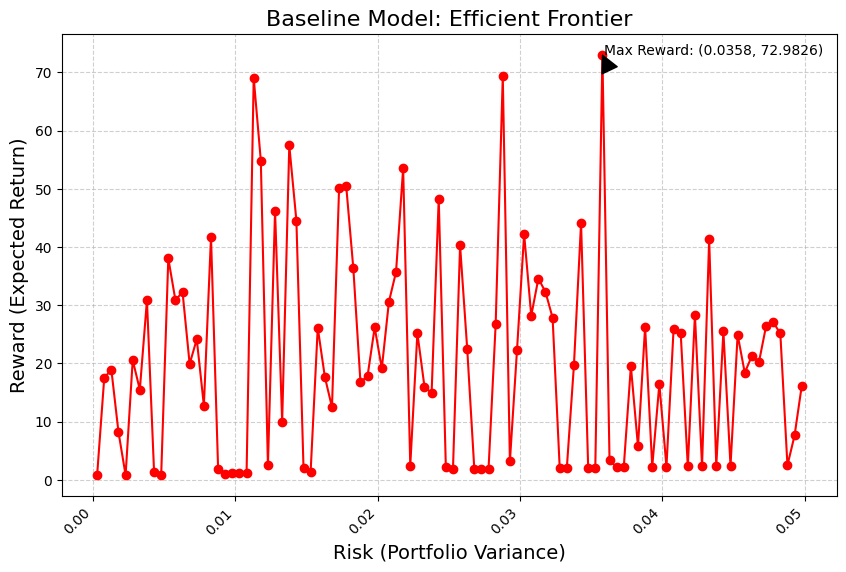

Baseline Model Risk and Reward:
  Risk Level 1: Risk = 0.0003, Reward = 0.8308
  Risk Level 2: Risk = 0.0008, Reward = 17.5512
  Risk Level 3: Risk = 0.0013, Reward = 18.9261
  Risk Level 4: Risk = 0.0018, Reward = 8.2198
  Risk Level 5: Risk = 0.0023, Reward = 0.8308
  Risk Level 6: Risk = 0.0028, Reward = 20.5762
  Risk Level 7: Risk = 0.0033, Reward = 15.5021
  Risk Level 8: Risk = 0.0038, Reward = 30.8674
  Risk Level 9: Risk = 0.0043, Reward = 1.4118
  Risk Level 10: Risk = 0.0048, Reward = 0.8308
  Risk Level 11: Risk = 0.0053, Reward = 38.0546
  Risk Level 12: Risk = 0.0058, Reward = 30.8816
  Risk Level 13: Risk = 0.0063, Reward = 32.2876
  Risk Level 14: Risk = 0.0068, Reward = 19.9148
  Risk Level 15: Risk = 0.0073, Reward = 24.1723
  Risk Level 16: Risk = 0.0078, Reward = 12.7611
  Risk Level 17: Risk = 0.0083, Reward = 41.7777
  Risk Level 18: Risk = 0.0088, Reward = 1.9108
  Risk Level 19: Risk = 0.0093, Reward = 1.0935
  Risk Level 20: Risk = 0.0098, Reward = 1.1225
  Ris

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(risk, reward, marker='o', linestyle='-', color='red')  # Changed color to red
plt.title('Baseline Model: Efficient Frontier', fontsize=16)  # Updated title
plt.xlabel('Risk (Portfolio Variance)', fontsize=14)
plt.ylabel('Reward (Expected Return)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
# Find and annotate the point with the maximum reward for the baseline model
max_reward_index = np.argmax(reward)
plt.annotate(f'Max Reward: ({risk[max_reward_index]:.4f}, {reward[max_reward_index]:.4f})',
             xy=(risk[max_reward_index], reward[max_reward_index]),
             xytext=(risk[max_reward_index] + 0.0001, reward[max_reward_index] + 0.001),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()
print("Baseline Model Risk and Reward:")
for i, r in enumerate(risk):
    print(f"  Risk Level {i+1}: Risk = {r:.4f}, Reward = {reward[i]:.4f}")

Analysis of the Efficient Frontier Baseline Graph

- The efficient frontier shows the set of portfolios that offer the highest expected return for a given level of risk.

- General Trend:

The data points are scattered, showing no clear upward trend as risk increases. This suggests that the relationship between risk and return in this baseline scenario is not straightforward or consistently positive.

- "Max Reward":

The current return is around 16 but it also has a relatively high risk of around 5%. Therefore, given the constraints, stock portfolio would actually yield much higher returns to 73 when the risk is dialed back (from 5% to around 3.58%).

#Model 1 (2.0558% Risk - 24.66% Return)

The risk and return levels chosen for this scenario is meant to help Nancy beat the YTD returns of the S&P500 (24.66%) whilst maintaining his usual risk appetite.

The metric used to gauge his risk appetite is the 95% VAR (Value at Risk) which came to be 2.0558% as previously explored in the EDA section of this project. This metric indicates that Pete may have a 95% chance of not losing more than 2% of his investment capital at a given time period which is from 1/1/24 to 1/14/25 in this case.

## Setting Up the Constraints

In [ ]:
# Update constraints to include new tickers
m.total_risk = Constraint(expr = m.AAPL + m.MSFT + m.GOOGL + m.TSLA + m.V + m.PANW + m.AVGO + m.NVDA + m.AMZN + m.TEM <= 0.020558)
m.sum_proportion = Constraint(expr = m.AAPL + m.MSFT + m.GOOGL + m.TSLA + m.V + m.PANW + m.AVGO + m.NVDA + m.AMZN + m.TEM == 1)
m.return_floor = Constraint(expr = m.objective >= 0.2466) # min return = 1%

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


The constraints in the optimization model are designed to achieve a well-balanced portfolio while adhering to key investment guidelines.

- The total risk constraint ensures that the combined risk of all assets in the portfolio does not exceed 2%, thus limiting the overall exposure to volatility or uncertainty.

- The sum of proportions constraint encourages optimal capital utilization.

- Additionally, the return floor constraint sets a minimum required return of 24.66%, ensuring that the model only considers portfolios that meet or exceed this threshold.

Together, these constraints help optimize the portfolio by balancing risk, return, and full utilization of the available capital.

## Computing Portfolio's Variance (Risk)

In [ ]:
# prompt: expr_risk = calc_risk(m)
# IndexError: index 10 is out of bounds for axis 0 with size 10

# Update the variables list and tickers list in calc_risk function
def calc_risk(m):
    variables = [m.AAPL, m.MSFT, m.GOOGL, m.TSLA, m.V, m.PANW, m.AVGO, m.NVDA, m.AMZN, m.TEM]
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'V', 'PANW', 'AVGO', 'NVDA', 'AMZN', 'TEM']
    risk_exp = 0
    for i in range(len(variables)):
        for j in range(len(variables)):
            try:
                risk_exp += variables[i] * variables[j] * nancy_stock_data_cov.iloc[i, j]
            except IndexError:
                print(f"IndexError: i={i}, j={j}")
                # Handle the IndexError appropriately, e.g., skip the problematic indices
                # or assign a default value to risk_exp.
                continue # skip this pair of indices
    return risk_exp
expr_risk = calc_risk(m)


In [ ]:
max_risk = 0.020558

This is in line with the risk constraint we set at 2%.

In [ ]:
import numpy as np

risk_limits = np.arange(0.0003, max_risk, 0.0005)
risk_limits

array([0.0003, 0.0008, 0.0013, 0.0018, 0.0023, 0.0028, 0.0033, 0.0038,
       0.0043, 0.0048, 0.0053, 0.0058, 0.0063, 0.0068, 0.0073, 0.0078,
       0.0083, 0.0088, 0.0093, 0.0098, 0.0103, 0.0108, 0.0113, 0.0118,
       0.0123, 0.0128, 0.0133, 0.0138, 0.0143, 0.0148, 0.0153, 0.0158,
       0.0163, 0.0168, 0.0173, 0.0178, 0.0183, 0.0188, 0.0193, 0.0198,
       0.0203])

## Calculating Iterations of Different Risk Limits

In [ ]:
param_analysis = {}
returns = {}
for r in risk_limits:
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()
  param_analysis[r] = [m.AAPL(), m.MSFT(), m.GOOGL(), m.TSLA(), m.V(), m.PANW(), m.AVGO(), m.NVDA(), m.AMZN(), m.TEM()]
  returns[r] =  m.AAPL()*nancy_stock_data_return['AAPL'] + m.MSFT()*nancy_stock_data_return['MSFT'] + m.GOOGL()*nancy_stock_data_return['GOOGL'] + m.TSLA()*nancy_stock_data_return['TSLA'] + m.V()*nancy_stock_data_return['V'] + m.PANW()*nancy_stock_data_return['PANW'] + m.AVGO()*nancy_stock_data_return['AVGO'] + m.NVDA()*nancy_stock_data_return['NVDA'] + m.AMZN()*nancy_stock_data_return['AMZN'] + m.TEM()*nancy_stock_data_return['TEM']

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.239746332168579
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.14911365509033203
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.5270113945007324
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.13066577911376953
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3660693168640137
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.839770793914795
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2708799839019775
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2548277378082275
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09625363349914551
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.17955732345581055
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2358458042144775
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2123713493347168
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.4243035316467285
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2460083961486816
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2790310382843018
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.19115471839904785
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.299145221710205
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.29312634468078613
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2772853374481201
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07878661155700684
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.0891258716583252
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.11929965019226074
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05552101135253906
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.8501534461975098
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.36975765228271484
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.24347877502441406
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3649718761444092
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2387988567352295
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3460414409637451
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.17749404907226562
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.18615198135375977
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.050508737564086914
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1607928276062012
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1935994625091553
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.385094404220581
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3117375373840332
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08722853660583496
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.363265037536621
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09417605400085449
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.711045742034912
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2077746391296387
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

## Optimal Stock Allocation for Different Risk Levels

<Figure size 2500x800 with 0 Axes>

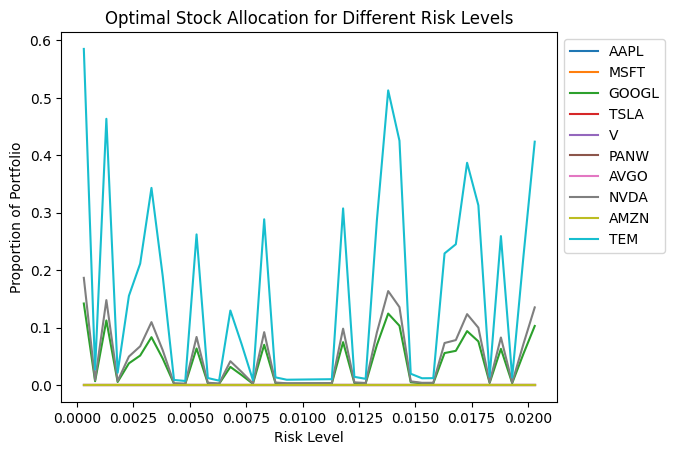

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'V', 'PANW', 'AVGO', 'NVDA', 'AMZN', 'TEM']

plt.figure(figsize=(25, 8))  # Increased figure size
ax = param_analysis.plot()

plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Proportion of Portfolio')

# Move the legend outside the chart
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


The stock allocations at different risk levels are very similar to that of the baseline, with the same 3 stocks (TEM, NVDA, and GOOGL) being allocated at similar degrees. However, it seems that the allocation amounts are higher. More of the investment capital is being used and allocated into these stocks.

In [ ]:
# prompt: proportion of the stock at 5%

# Assuming 'param_analysis' DataFrame is already created as in the provided code.

# Access the row corresponding to a 5% risk level (or the closest available value).
risk_level_2_percent = 0.020558  # Or find the closest value in risk_limits

# Check if 5% risk is exactly in the index. If not use .loc to handle potential KeyError
if risk_level_2_percent in param_analysis.index:
  portfolio_at_2_percent = param_analysis.loc[risk_level_2_percent]
else:
    # Find the closest risk level to 5%
    closest_risk_level = min(param_analysis.index, key=lambda x: abs(x - risk_level_2_percent))
    portfolio_at_2_percent = param_analysis.loc[closest_risk_level]

print(f"Stock proportions at or near 2% risk level:\n{portfolio_at_2_percent}")


Stock proportions at or near 2% risk level:
AAPL     0.000000
MSFT     0.000000
GOOGL    0.102664
TSLA     0.000000
V        0.000000
PANW     0.000000
AVGO     0.000000
NVDA     0.135031
AMZN     0.000000
TEM      0.423730
Name: 0.020300000000000002, dtype: float64


At 2% risk, the total allocation for the TEM, NVDA, and GOOGL portfolio sums to approximately 20.77%, leaving a slack of about 80% just like the baseline portfolio. This means that a significant portion of the portfolio's capital is unallocated. In practice, this uninvested capital acts as a buffer that helps manage risk by reducing overall market exposure. However, the trade-off is that potential returns are also limited since a large amount of capital is not actively working in the market. Portfolio managers might deliberately maintain this slack to achieve a desired risk level, such as a 2% risk threshold, in line with the principles of Modern Portfolio Theory. This approach ensures that the portfolio remains within the investor's risk tolerance while sacrificing some growth potential.

## Efficient Frontier

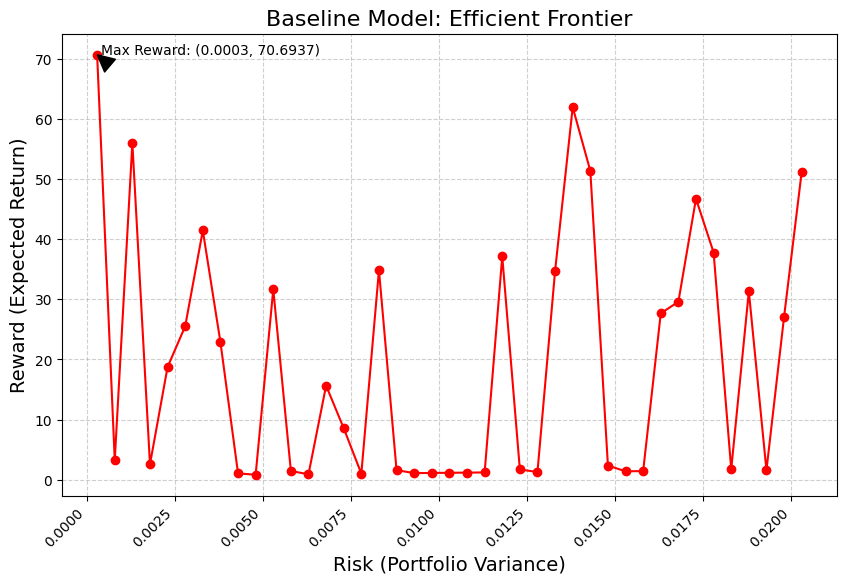

Baseline Model Risk and Reward:
  Risk Level 1: Risk = 0.0003, Reward = 70.6937
  Risk Level 2: Risk = 0.0008, Reward = 3.2334
  Risk Level 3: Risk = 0.0013, Reward = 55.9926
  Risk Level 4: Risk = 0.0018, Reward = 2.5610
  Risk Level 5: Risk = 0.0023, Reward = 18.7459
  Risk Level 6: Risk = 0.0028, Reward = 25.5213
  Risk Level 7: Risk = 0.0033, Reward = 41.4547
  Risk Level 8: Risk = 0.0038, Reward = 22.8893
  Risk Level 9: Risk = 0.0043, Reward = 1.0469
  Risk Level 10: Risk = 0.0048, Reward = 0.8308
  Risk Level 11: Risk = 0.0053, Reward = 31.6695
  Risk Level 12: Risk = 0.0058, Reward = 1.4485
  Risk Level 13: Risk = 0.0063, Reward = 0.9000
  Risk Level 14: Risk = 0.0068, Reward = 15.6513
  Risk Level 15: Risk = 0.0073, Reward = 8.5610
  Risk Level 16: Risk = 0.0078, Reward = 1.0014
  Risk Level 17: Risk = 0.0083, Reward = 34.8491
  Risk Level 18: Risk = 0.0088, Reward = 1.5939
  Risk Level 19: Risk = 0.0093, Reward = 1.0935
  Risk Level 20: Risk = 0.0098, Reward = 1.1225
  Risk L

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Assuming 'returns' dictionary is already populated from the baseline model.
risk = list(returns.keys())  # coerce dict_keys to a list
reward = list(returns.values())  # coerce dict_values to a list
plt.figure(figsize=(10, 6))
plt.plot(risk, reward, marker='o', linestyle='-', color='red')  # Changed color to red
plt.title('Baseline Model: Efficient Frontier', fontsize=16)  # Updated title
plt.xlabel('Risk (Portfolio Variance)', fontsize=14)
plt.ylabel('Reward (Expected Return)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
# Find and annotate the point with the maximum reward for the baseline model
max_reward_index = np.argmax(reward)
plt.annotate(f'Max Reward: ({risk[max_reward_index]:.4f}, {reward[max_reward_index]:.4f})',
             xy=(risk[max_reward_index], reward[max_reward_index]),
             xytext=(risk[max_reward_index] + 0.0001, reward[max_reward_index] + 0.001),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()
print("Baseline Model Risk and Reward:")
for i, r in enumerate(risk):
    print(f"  Risk Level {i+1}: Risk = {r:.4f}, Reward = {reward[i]:.4f}")


Analysis of the Efficient Frontier Baseline Graph

- The efficient frontier shows the set of portfolios that offer the highest expected return for a given level of risk.

- General Trend:

The data points are scattered, showing no clear upward trend as risk increases. This suggests that the relationship between risk and return in this baseline scenario is not straightforward or consistently positive.

- "Max Reward":
The current return is around 51 with risk of around 2%. Therefore, given the constraints, stock portfolio would actually yield much higher returns to 70.7 when the risk is dialed back to near 0 (0.0003).

#Model 2 (2.0558% Risk - 130% Return)

The risk and return levels chosen for this scenario is meant to help Nancy maintain her annualized returns of 130% (takes paid in capital into consideration) whilst maintaining her usual risk appetite.

The metric used to gauge her risk appetite is the 95% VAR (Value at Risk) which came to be 1.2446%.

## Setting Up the Constraints

In [ ]:
# Update constraints to include new tickers
m.total_risk = Constraint(expr = m.AAPL + m.MSFT + m.GOOGL + m.TSLA + m.V + m.PANW + m.AVGO + m.NVDA + m.AMZN + m.TEM <= 0.020558)
m.sum_proportion = Constraint(expr = m.AAPL + m.MSFT + m.GOOGL + m.TSLA + m.V + m.PANW + m.AVGO + m.NVDA + m.AMZN + m.TEM == 1)
m.return_floor = Constraint(expr = m.objective >= 1.3) # min return = 1%

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


The constraints in the optimization model are designed to achieve a well-balanced portfolio while adhering to key investment guidelines.

The total risk constraint ensures that the combined risk of all assets in the portfolio does not exceed 2.0558%, thus limiting the overall exposure to volatility or uncertainty.

The sum of proportions constraint encourages optimal capital utilization.

Additionally, the return floor constraint sets a minimum required return of 130%, ensuring that the model only considers portfolios that meet or exceed this threshold.

Together, these constraints help optimize the portfolio by balancing risk, return, and full utilization of the available capital.

## Computing Portfolio Variance (Risk)

In [ ]:
# prompt: expr_risk = calc_risk(m)
# IndexError: index 10 is out of bounds for axis 0 with size 10

# Update the variables list and tickers list in calc_risk function
def calc_risk(m):
    variables = [m.AAPL, m.MSFT, m.GOOGL, m.TSLA, m.V, m.PANW, m.AVGO, m.NVDA, m.AMZN, m.TEM]
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'V', 'PANW', 'AVGO', 'NVDA', 'AMZN', 'TEM']
    risk_exp = 0
    for i in range(len(variables)):
        for j in range(len(variables)):
            try:
                risk_exp += variables[i] * variables[j] * nancy_stock_data_cov.iloc[i, j]
            except IndexError:
                print(f"IndexError: i={i}, j={j}")
                # Handle the IndexError appropriately, e.g., skip the problematic indices
                # or assign a default value to risk_exp.
                continue # skip this pair of indices
    return risk_exp
expr_risk = calc_risk(m)


In [ ]:
max_risk = 0.020558

This is in line with the risk constraint we set at 2%.

In [ ]:
import numpy as np

risk_limits = np.arange(0.0003, max_risk, 0.0005)
risk_limits

array([0.0003, 0.0008, 0.0013, 0.0018, 0.0023, 0.0028, 0.0033, 0.0038,
       0.0043, 0.0048, 0.0053, 0.0058, 0.0063, 0.0068, 0.0073, 0.0078,
       0.0083, 0.0088, 0.0093, 0.0098, 0.0103, 0.0108, 0.0113, 0.0118,
       0.0123, 0.0128, 0.0133, 0.0138, 0.0143, 0.0148, 0.0153, 0.0158,
       0.0163, 0.0168, 0.0173, 0.0178, 0.0183, 0.0188, 0.0193, 0.0198,
       0.0203])

## Calculating Iterations of Different Risk Limits

In [ ]:
param_analysis = {}
returns = {}
for r in risk_limits:
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()
  param_analysis[r] = [m.AAPL(), m.MSFT(), m.GOOGL(), m.TSLA(), m.V(), m.PANW(), m.AVGO(), m.NVDA(), m.AMZN(), m.TEM()]
  returns[r] =  m.AAPL()*nancy_stock_data_return['AAPL'] + m.MSFT()*nancy_stock_data_return['MSFT'] + m.GOOGL()*nancy_stock_data_return['GOOGL'] + m.TSLA()*nancy_stock_data_return['TSLA'] + m.V()*nancy_stock_data_return['V'] + m.PANW()*nancy_stock_data_return['PANW'] + m.AVGO()*nancy_stock_data_return['AVGO'] + m.NVDA()*nancy_stock_data_return['NVDA'] + m.AMZN()*nancy_stock_data_return['AMZN'] + m.TEM()*nancy_stock_data_return['TEM']

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1955482959747314
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2011921405792236
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.24948763847351074
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2000916004180908
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1231236457824707
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2771129608154297
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.255671739578247
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3667285442352295
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.9623558521270752
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.4417004585266113
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2241954803466797
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07720017433166504
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.21728229522705078
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1702759265899658
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.378873348236084
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1906962394714355
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08390688896179199
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.20306968688964844
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2556140422821045
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2156381607055664
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.26805758476257324
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.571610927581787
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of so

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.7630298137664795
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2773857116699219
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1474757194519043
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2794301509857178
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3324625492095947
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.0717976093292236
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.2877416610717773
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09937906265258789
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1384270191192627
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10773396492004395
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2393636703491211
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.1772689819335938
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.16634631156921387
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.7188982963562012
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.4206998348236084
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.0723659992218018
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10526514053344727
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: maxIterations
  - message from solver: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Maximum Number of Iterations Exceeded.
  Termination condition: maxIterations
  Id: 400
  Error rc: 0
  Time: 1.3312945365905762
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07832217216491699
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

## Optimal Stock Allocation for Different Risk Levels

<Figure size 2500x800 with 0 Axes>

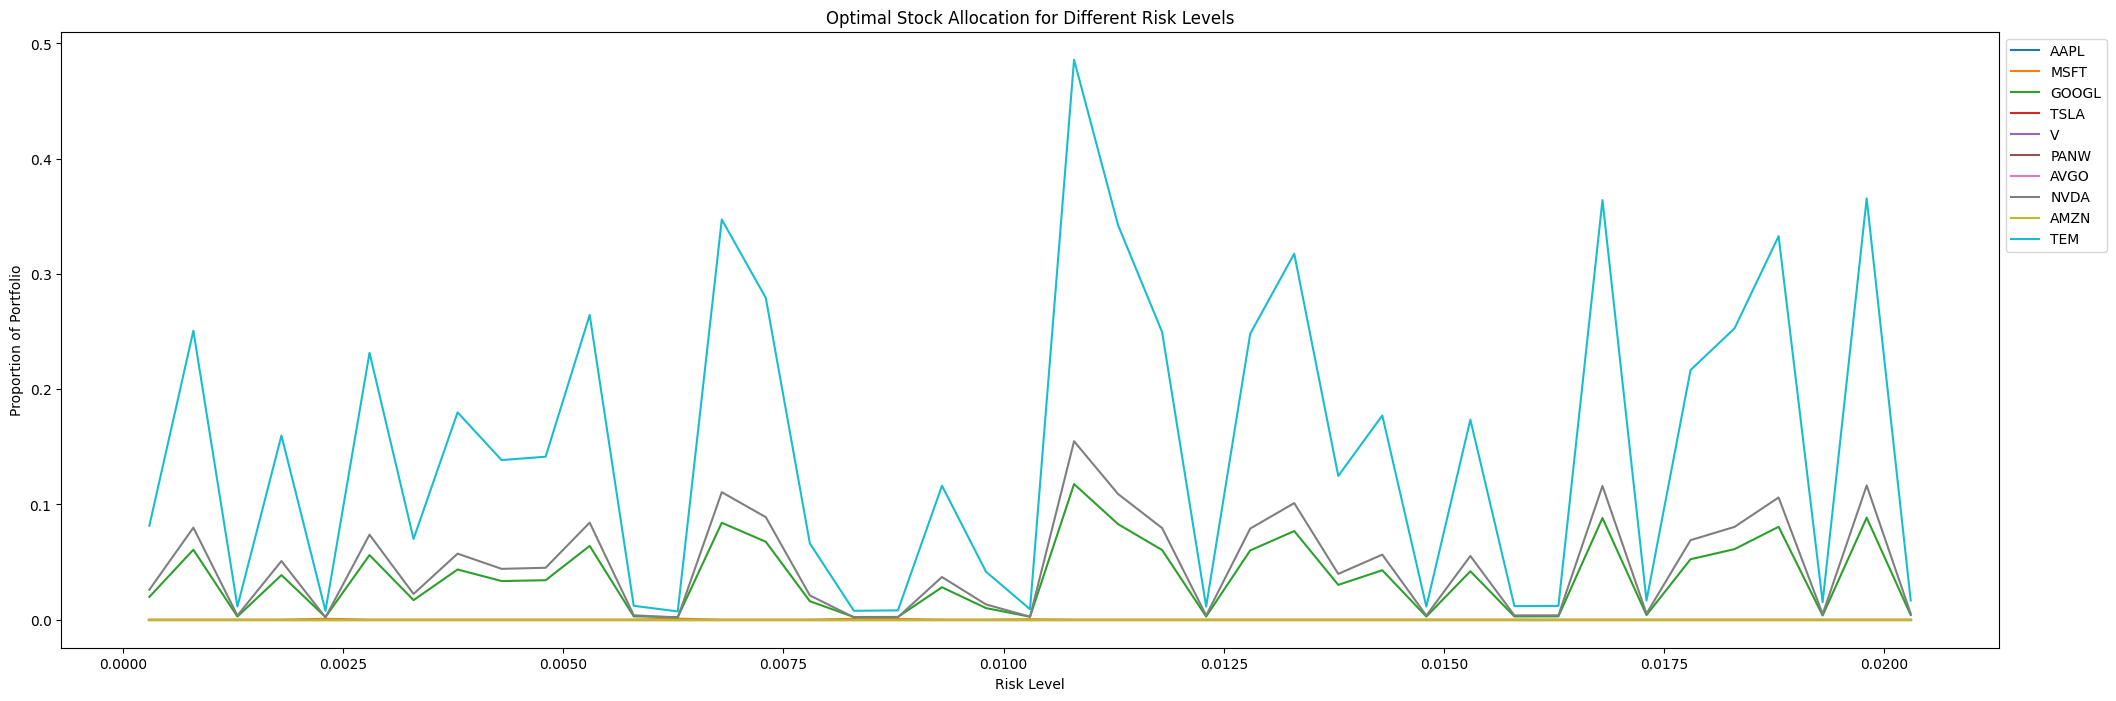

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'V', 'PANW', 'AVGO', 'NVDA', 'AMZN', 'TEM']

plt.figure(figsize=(25, 8))  # Increased figure size
ax = param_analysis.plot(figsize=(25, 8))

plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Proportion of Portfolio')

# Move the legend outside the chart
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


The stock allocations at different risk levels are very similar to that of the baseline, with the same 3 stocks (TEM, NVDA, and GOOGL) being allocated at similar degrees. However, it seems that the allocation amounts are higher. More of the investment capital is being used and allocated into these stocks. However, as seen in the risk level of 2% the allocated investment capital reduces greatly.

In [ ]:
# prompt: proportion of the stock at 5%

# Assuming 'param_analysis' DataFrame is already created as in the provided code.

# Access the row corresponding to a 5% risk level (or the closest available value).
risk_level_2_percent = 0.020558  # Or find the closest value in risk_limits

# Check if 5% risk is exactly in the index. If not use .loc to handle potential KeyError
if risk_level_2_percent in param_analysis.index:
  portfolio_at_2_percent = param_analysis.loc[risk_level_2_percent]
else:
    # Find the closest risk level to 5%
    closest_risk_level = min(param_analysis.index, key=lambda x: abs(x - risk_level_2_percent))
    portfolio_at_2_percent = param_analysis.loc[closest_risk_level]

print(f"Stock proportions at or near 2% risk level:\n{portfolio_at_2_percent}")


Stock proportions at or near 2% risk level:
AAPL     0.000000
MSFT     0.000000
GOOGL    0.004050
TSLA     0.000000
V        0.000000
PANW     0.000000
AVGO     0.000000
NVDA     0.005327
AMZN     0.000000
TEM      0.016715
Name: 0.020300000000000002, dtype: float64


At 2% risk, the total allocation for the TEM, NVDA, and GOOGL portfolio sums to approximately 2.6%, leaving a slack of about 97.4% just like the baseline portfolio. This means that a significant portion of the portfolio's capital is unallocated. In practice, this uninvested capital acts as a buffer that helps manage risk by reducing overall market exposure. However, the trade-off is that potential returns are also limited since a large amount of capital is not actively working in the market. Portfolio managers might deliberately maintain this slack to achieve a desired risk level, such as a 2% risk threshold, in line with the principles of Modern Portfolio Theory. This approach ensures that the portfolio remains within the investor's risk tolerance while sacrificing some growth potential.

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward)

[0.0003, 0.0007999999999999999, 0.0013, 0.0018, 0.0023, 0.0028, 0.0033, 0.0038, 0.0043, 0.0048000000000000004, 0.0053, 0.0058, 0.0063, 0.0068000000000000005, 0.0073, 0.0078, 0.0083, 0.0088, 0.009300000000000001, 0.0098, 0.0103, 0.0108, 0.0113, 0.0118, 0.0123, 0.0128, 0.013300000000000001, 0.0138, 0.0143, 0.0148, 0.0153, 0.0158, 0.016300000000000002, 0.016800000000000002, 0.017300000000000003, 0.017800000000000003, 0.018300000000000004, 0.0188, 0.0193, 0.0198, 0.020300000000000002]
[9.846093374383575, 30.280722340643322, 1.3849749484699574, 19.302285225058867, 1.3000122362232114, 27.963126230153648, 8.46871415368392, 21.72714769230234, 16.725626702723005, 17.08384388174347, 31.933039426331575, 1.4605475261633079, 1.3000122389860587, 41.93480738213299, 33.71647182485272, 7.998522442665171, 1.3000122312925768, 1.300012236264823, 14.040542997499383, 5.034046181449681, 1.3000122399154346, 58.680851750328586, 41.3369857024869, 30.14174949186382, 1.3786187574348128, 29.964027673149822, 38.352

## Efficient Frontier

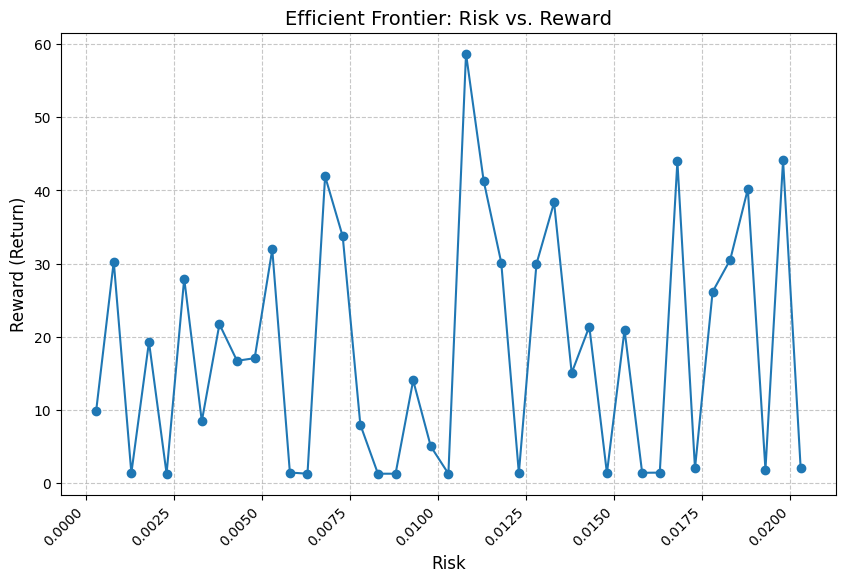

Risk Levels:
  1. Risk: 0.0003, Reward: 9.8461
  2. Risk: 0.0008, Reward: 30.2807
  3. Risk: 0.0013, Reward: 1.3850
  4. Risk: 0.0018, Reward: 19.3023
  5. Risk: 0.0023, Reward: 1.3000
  6. Risk: 0.0028, Reward: 27.9631
  7. Risk: 0.0033, Reward: 8.4687
  8. Risk: 0.0038, Reward: 21.7271
  9. Risk: 0.0043, Reward: 16.7256
  10. Risk: 0.0048, Reward: 17.0838
  11. Risk: 0.0053, Reward: 31.9330
  12. Risk: 0.0058, Reward: 1.4605
  13. Risk: 0.0063, Reward: 1.3000
  14. Risk: 0.0068, Reward: 41.9348
  15. Risk: 0.0073, Reward: 33.7165
  16. Risk: 0.0078, Reward: 7.9985
  17. Risk: 0.0083, Reward: 1.3000
  18. Risk: 0.0088, Reward: 1.3000
  19. Risk: 0.0093, Reward: 14.0405
  20. Risk: 0.0098, Reward: 5.0340
  21. Risk: 0.0103, Reward: 1.3000
  22. Risk: 0.0108, Reward: 58.6809
  23. Risk: 0.0113, Reward: 41.3370
  24. Risk: 0.0118, Reward: 30.1417
  25. Risk: 0.0123, Reward: 1.3786
  26. Risk: 0.0128, Reward: 29.9640
  27. Risk: 0.0133, Reward: 38.3526
  28. Risk: 0.0138, Reward: 15.0687


In [ ]:
# prompt: # subset
# risk = list(returns.keys()) # coerce dict_keys to a list
# print(risk)
# reward = list(returns.values()) # coerce dict_values to a list
# print(reward)
# make this more presentable and informative

import numpy as np
import matplotlib.pyplot as plt

# Assuming 'returns' dictionary is already populated.

plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
plt.plot(risk, reward, '-o')  # Use markers for better visualization

# Add labels and title with improved formatting
plt.title('Efficient Frontier: Risk vs. Reward', fontsize=14)
plt.xlabel('Risk', fontsize=12)
plt.ylabel('Reward (Return)', fontsize=12)

# Customize ticks and grid for clarity
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.grid(True, linestyle='--', alpha=0.7) # Add a subtle grid for better readability

# Annotate key points (optional)
# For example, to annotate the point with maximum reward
# max_reward_index = np.argmax(reward)
# plt.annotate(f'Max Reward: ({risk[max_reward_index]:.3f}, {reward[max_reward_index]:.3f})',
#             xy=(risk[max_reward_index], reward[max_reward_index]),
#             xytext=(risk[max_reward_index] + 0.001, reward[max_reward_index] + 0.001),  # Adjust text position
#             arrowprops=dict(facecolor='black', shrink=0.05))

# Show the plot
plt.show()

# Print risk and reward in a more informative way
print("Risk Levels:")
for i, r in enumerate(risk):
    print(f"  {i+1}. Risk: {r:.4f}, Reward: {reward[i]:.4f}")


Analysis of the Efficient Frontier Baseline Graph

- The efficient frontier shows the set of portfolios that offer the highest expected return for a given level of risk.

- General Trend:

The data points are scattered, showing no clear upward trend as risk increases. This suggests that the relationship between risk and return in this baseline scenario is not straightforward or consistently positive.

- "Max Reward":

The current return is only 2 with risk of around 2%. Therefore, given the constraints, stock portfolio would actually yield much higher returns to near 60 when the risk is dialed back (from 2% to around 1.1%).

After analyzing the three portfolio allocations (with total allocations of approximately 20.77%, 66.14%, and 2.61%), a consistent and noteworthy pattern emerges:

1. Dominance of TEM  
   - Across all three portfolios, TEM consistently holds the majority of the allocated capital. Its allocation is by far the highest compared to the other two stocks, indicating that the optimizer strongly favors TEM as the primary asset.

2. Supporting Roles of NVDA and GOOGL  
   - NVDA and GOOGL are the only other stocks included in the allocations, and they appear at similar, much lower levels relative to TEM.  
   - Their consistent, modest allocations suggest that they are used as complementary or hedging assets rather than as core drivers of portfolio returns.

3. Overall Capital Utilization and Slack  
   - The sum of the allocations in each scenario is significantly less than 100%—approximately 20.77%, 66.14%, and 2.61%.  
   - This discrepancy indicates that a substantial portion of the portfolio's capital is unallocated, or held in cash/equivalents, providing a buffer against risk but also limiting potential returns.

4. Sensitivity to Risk Levels and Target Returns  
   - The variation in total allocated percentages across the three portfolios suggests that the optimizer adjusts overall exposure based on the desired risk level and expected return.  
   - While the specific allocation to TEM, NVDA, and GOOGL remains consistent, the differing total investment percentages imply different risk profiles, with one portfolio taking on much higher active exposure than another.

5. Model-Specific Assumptions and Strategy  
   - The repeated selection of only TEM, NVDA, and GOOGL across varying allocation levels indicates that the model is built around a specific risk-return profile where these assets are deemed optimal.  
   - This focused allocation, combined with significant slack, reflects a deliberate strategy to balance potential returns with risk management, adhering to the model’s assumptions about asset performance and volatility.

Final Takeaway:  
The consistent inclusion of TEM as the dominant holding, supported by modest allocations to NVDA and GOOGL, underscores a focused investment approach. The significant unallocated capital (slack) in each scenario is a deliberate mechanism to manage risk, resulting in varying overall exposure. Despite differences in total allocation percentages, the underlying strategy remains consistent—emphasizing TEM's favorable risk-return characteristics while using NVDA and GOOGL to complement the portfolio under different risk and return targets.

# Pete Sessions Stock Allocation

In [ ]:
pete_stock_data.head()

,CCI,AAPL,GIS,NVST,MO,MSFT,V,NVDA,AMZN,GOOGL
Date,,,,,,,,,,
2024-01-02,109.903191,184.532074,63.780903,24.100000,38.290985,367.380585,256.474701,48.154346,149.929993,137.670929
2024-01-03,106.953461,183.150375,63.761806,23.459999,38.125221,367.113159,255.592987,47.555515,148.470001,138.418228
2024-01-04,107.434090,180.824341,62.815830,23.379999,38.235729,364.478180,257.207855,47.984398,144.570007,135.897354
2024-01-05,107.217323,180.098694,62.099186,23.379999,38.208107,364.289978,257.287170,49.083080,145.240005,135.239746
2024-01-08,108.150314,184.452560,61.764763,24.030001,38.594879,371.164673,260.110809,52.238186,149.100006,138.338516


# Decision Variables

These are the decision variables we will use to build the non-linear optimization model for Pete's Sessions, aimed at maximizing return and minimizing risk:

1. CCI
2. AAPL  
3. GIS  
4. NVST  
5. MO  
6. MSFT  
7. V  
8. NVDA  
9. AMZN  
10. GOOGLE

In [ ]:
m.CCI=Var(domain=NonNegativeReals, bounds=(0,1))
m.AAPL=Var(domain=NonNegativeReals, bounds=(0,1))
m.GIS=Var(domain=NonNegativeReals, bounds=(0,1))
m.NVST=Var(domain=NonNegativeReals, bounds=(0,1))
m.MO=Var(domain=NonNegativeReals, bounds=(0,1))
m.MSFT=Var(domain=NonNegativeReals, bounds=(0,1))
m.V=Var(domain=NonNegativeReals, bounds=(0,1))
m.NVDA=Var(domain=NonNegativeReals, bounds=(0,1))
m.AMZN=Var(domain=NonNegativeReals, bounds=(0,1))
m.GOOGL=Var(domain=NonNegativeReals, bounds=(0,1))

# bounds 0 and 1, meaning it can 0.1, 0.2, ... 1

This block of code is defining decision variables for a non-linear optimization model. Each variable represents the proportion or allocation of an asset (stock) in the portfolio. Here's a detailed breakdown:

**Explanation of Each Line:**
1. m.CCI = Var(domain=NonNegativeReals, bounds=(0, 1))
   - m.CCI: This is a decision variable representing the proportion allocated to Crown Castle (CCI) in the portfolio.
   - domain=NonNegativeReals: This means the variable must be a non-negative real number (i.e., no negative values, such as -0.5).
   - bounds=(0, 1): The variable is bounded between 0 and 1, meaning the allocation to CCI can range from 0 (no investment) to 1 (fully invested in CCI). Any fractional value like 0.1, 0.5, 0.9, etc., is allowed within this range.
   
Each of these variables (m.CCI, m.AAPL, m.GIS, etc.) will be part of the optimization model. These variables will represent the fraction of the total portfolio allocated to each respective stock.

# Objective Function - MAX (Return)

In [ ]:
m.Objective=Objective(expr=m.CCI*pete_stock_data_return['CCI'] +
                      m.AAPL * pete_stock_data_return['AAPL'] +
                      m.GIS*pete_stock_data_return['GIS'] +
                      m.NVST*pete_stock_data_return['NVST'] +
                      m.MO*pete_stock_data_return['MO'] +
                      m.MSFT*pete_stock_data_return['MSFT'] +
                      m.V*pete_stock_data_return['V'] +
                      m.NVDA*pete_stock_data_return['NVDA'] +
                      m.AMZN*pete_stock_data_return['AMZN'] +
                      m.GOOGL*pete_stock_data_return['GOOGL'], sense=maximize)

This line of code defines the objective function for your optimization model, which aims to **maximize** the return of the portfolio by allocating investments across various stocks.

- m.Objective:  
  This creates an objective function named Objective in the optimization model m. The goal of this function is to be maximized, meaning the optimization process will attempt to maximize the expression defined within expr.

- The optimization model will adjust the allocations (m.CCI, m.AAPL, etc.) within the bounds specified earlier (0 to 1) to maximize the total return.


#Baseline (5% Risk - 1% Return)

The risk and return levels chosen for this scenario is meant to reflect an average person's investment profile. If Pete was bearish in terms of risk levels, and just willing to accept minimum returns and stay conservative.

## Setting Up the Constraints

In [ ]:
m.total_risk = Constraint(expr = m.CCI + m.AAPL + m.GIS + m.NVST + m.MO + m.MSFT + m.V + m.NVDA + m.AMZN + m.GOOGL <= 0.05) # risk is less than 5%
m.sum_proportion = Constraint(expr = m.CCI + m.AAPL + m.GIS + m.NVST + m.MO + m.MSFT + m.V + m.NVDA + m.AMZN + m.GOOGL == 1) # all stocks = 100
m.return_floor = Constraint(expr = m.Objective >= 0.01) # min return = 1%

The constraints in the optimization model are designed to achieve a well-balanced portfolio while adhering to key investment guidelines.

- The total risk constraint ensures that the combined risk of all assets in the portfolio does not exceed 5%, thus limiting the overall exposure to volatility or uncertainty.

- The sum of proportions constraint encourages optimal capital utilization.

- Additionally, the return floor constraint sets a minimum required return of 1%, ensuring that the model only considers portfolios that meet or exceed this threshold.

Together, these constraints help optimize the portfolio by balancing risk, return, and full utilization of the available capital.

## Computing Portfolio's Variance (Risk)

In [ ]:
def calc_risk(m):
  variables = [m.CCI, m.AAPL, m.GIS, m.NVST, m.MO, m.MSFT, m.V, m.NVDA, m.AMZN, m.GOOGL ]
  tickers = ['CCI', 'AAPL', 'GIS', 'NVST', 'MO', 'MSFT', 'V', 'NVDA', 'AMZN', 'GOOGL' ]
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      try:
        risk_exp += variables[i] * variables[j] * pete_stock_data_cov.iloc[i, j]
      except IndexError:
        print(f"IndexError: i={i}, j={j}")
  return risk_exp
expr_risk = calc_risk(m)

In [ ]:
max_risk = 0.05

This is in line with the risk constraint we set at 5%.

In [ ]:
import numpy as np

risk_limits = np.arange(0.0003, max_risk, 0.0005)
risk_limits

array([0.0003, 0.0008, 0.0013, 0.0018, 0.0023, 0.0028, 0.0033, 0.0038,
       0.0043, 0.0048, 0.0053, 0.0058, 0.0063, 0.0068, 0.0073, 0.0078,
       0.0083, 0.0088, 0.0093, 0.0098, 0.0103, 0.0108, 0.0113, 0.0118,
       0.0123, 0.0128, 0.0133, 0.0138, 0.0143, 0.0148, 0.0153, 0.0158,
       0.0163, 0.0168, 0.0173, 0.0178, 0.0183, 0.0188, 0.0193, 0.0198,
       0.0203, 0.0208, 0.0213, 0.0218, 0.0223, 0.0228, 0.0233, 0.0238,
       0.0243, 0.0248, 0.0253, 0.0258, 0.0263, 0.0268, 0.0273, 0.0278,
       0.0283, 0.0288, 0.0293, 0.0298, 0.0303, 0.0308, 0.0313, 0.0318,
       0.0323, 0.0328, 0.0333, 0.0338, 0.0343, 0.0348, 0.0353, 0.0358,
       0.0363, 0.0368, 0.0373, 0.0378, 0.0383, 0.0388, 0.0393, 0.0398,
       0.0403, 0.0408, 0.0413, 0.0418, 0.0423, 0.0428, 0.0433, 0.0438,
       0.0443, 0.0448, 0.0453, 0.0458, 0.0463, 0.0468, 0.0473, 0.0478,
       0.0483, 0.0488, 0.0493, 0.0498])

In [ ]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not shutil.which("ipopt"):
    # here is the IPOPT zip file
    !gdown 10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
    !unzip -o -q ipopt-linux64_dw
    assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

SOLVER = 'ipopt'
EXECUTABLE = '/content/ipopt'
ipopt_executable = '/content/ipopt'

Downloading...
From: https://drive.google.com/uc?id=10XRvLZqrpSNiXVAN-pipU52BVRwoGcNQ
To: /content/ipopt-linux64_dw.zip
100% 1.82M/1.82M [00:00<00:00, 36.3MB/s]


## Calculating Iterations of Different Risk Limits

In [ ]:
param_analysis = {}
returns = {}
for r in risk_limits:
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()
  param_analysis[r] = [m.CCI(), m.AAPL(), m.GIS(), m.NVST(), m.MO(), m.MSFT(), m.V(), m.NVDA(), m.AMZN(), m.GOOGL()]
  returns[r] =  m.CCI()*pete_stock_data_return['CCI'] + m.AAPL()*pete_stock_data_return['AAPL'] + m.GIS()*pete_stock_data_return['GIS'] + m.NVST()*pete_stock_data_return['NVST'] + m.MO()*pete_stock_data_return['MO'] + m.MSFT()*pete_stock_data_return['MSFT'] + m.V()*pete_stock_data_return['V'] + m.NVDA()*pete_stock_data_return['NVDA'] + m.AMZN()*pete_stock_data_return['AMZN'] + m.GOOGL()*pete_stock_data_return['GOOGL']

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1540532112121582
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.342876672744751
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08107471466064453
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1267106533050537
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.13906073570251465
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1858971118927002
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.13008761405944824
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.13203930854797363
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.059244632720947266
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.13950181007385254
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2893867492675781
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08789277076721191
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08332324028015137
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06995940208435059
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10607147216796875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.11108136177062988
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05224347114562988
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08004927635192871
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08812117576599121
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.15142560005187988
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.11867880821228027
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.044057369232177734
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.3187074661254883
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.42858386039733887
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.24834632873535156
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.15312957763671875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.3219153881072998
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07597231864929199
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07567310333251953
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.7103691101074219
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.40197086334228516
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.17745304107666016
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2580289840698242
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 1.530364751815796
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.6417443752288818
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.17171764373779297
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08590555191040039
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.12610340118408203
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06787395477294922
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08380842208862305
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2543675899505615
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.19234251976013184
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2517051696777344
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2201387882232666
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09878420829772949
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1782667636871338
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1867237091064453
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10268115997314453
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.14056134223937988
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.13189435005187988
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2121129035949707
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.5803256034851074
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2849762439727783
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.3647150993347168
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2597799301147461
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.12220597267150879
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.26125311851501465
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2434544563293457
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.43236422538757324
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.30826497077941895
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.27678871154785156
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.18778181076049805
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2872495651245117
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.26639437675476074
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.20933318138122559
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08670473098754883
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.15170907974243164
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09673810005187988
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.2446901798248291
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.3119394779205322
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.22355890274047852
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10832619667053223
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09001564979553223
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.03872871398925781
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04490327835083008
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.033925533294677734
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04302382469177246
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10832524299621582
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.046356201171875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of s

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.03420424461364746
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.0718393325805664
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.058817386627197266
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06751036643981934
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.0462641716003418
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05302095413208008
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.052181243896484375
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08666610717773438
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.09781312942504883
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07708430290222168
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08466529846191406
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.24227690696716309
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.044516563415527344
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.040506601333618164
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.14236116409301758
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05420327186584473
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06960391998291016
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07882165908813477
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07076096534729004
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07746076583862305
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04887652397155762
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

## Optimal Stock Allocation for Different Risk Levels

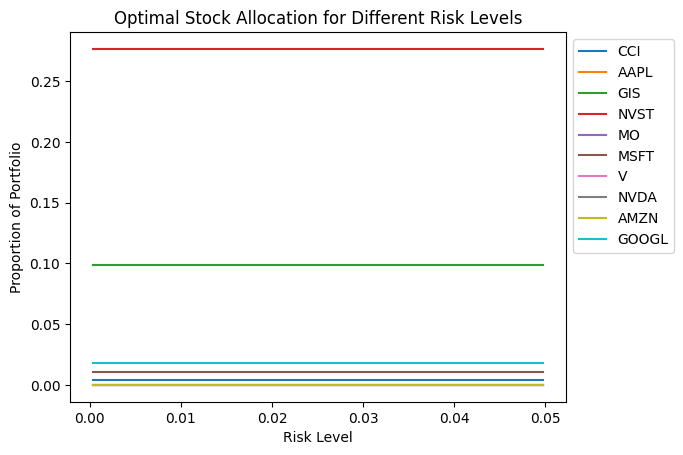

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['CCI', 'AAPL', 'GIS', 'NVST', 'MO', 'MSFT', 'V', 'NVDA', 'AMZN', 'GOOGL']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Proportion of Portfolio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Optimal stock allocation for different risk levels, focusing specifically on the 5% risk and 1% return scenario.

1. Flat Lines Indicate Constant Allocation:

The most striking feature is that all the lines are essentially flat across the entire range of risk levels. This means the optimal allocation for each stock remains constant regardless of the investor's risk tolerance.

2. Dominant Stocks:
    * CCI (Crown Castle): Has the highest allocation, around 27% of the portfolio. This suggests it's considered a core, stable holding, regardless of risk preference.
    * GIS (General Mills): Has the second-highest allocation, around 10%. This indicates it's also a relatively stable, defensive stock.

3. Low Allocation Stocks:

The remaining stocks (AAPL, NVST, MO, MSFT, V, NVDA, AMZN, and GOOGL) all have very low allocations, generally below 2% and some even below 1%. This implies they are considered less critical to the portfolio's overall performance and are not adjusted as risk tolerance changes.

4. Risk Level Insensitivity:

The graph suggests that the optimal portfolio strategy, as defined by this model, is insensitive to risk level.  Whether Pete is a highly conservative investor with a 0% risk tolerance or a moderately aggressive one with a 5% risk tolerance, the proportions of these stocks in your portfolio remain unchanged.

* 5% Risk: This refers to the rightmost point on the x-axis. The graph shows that even at this level, the stock allocations remain the same as at 0% risk.
* 1% Return: Since the graph doesn't explicitly show returns, we can infer that the model used to generate this graph likely predicts a very low expected return for this portfolio, potentially around 1% or even lower.  This is because the model allocates heavily to defensive stocks like CCI and GIS, which are known for stability rather than high growth.

Implications and Potential Concerns

* Limited Diversification: The heavy concentration in CCI and GIS suggests a lack of diversification. This could make the portfolio vulnerable to sector-specific risks or adverse events affecting those companies.
* Low Growth Potential: The focus on defensive stocks implies a low growth potential. This might be acceptable for highly risk-averse investors, but it could lead to underperformance compared to broader market indices during bull markets.
* Model Assumptions: The model used to generate this graph likely relies on specific assumptions about stock returns, volatility, and correlations. The validity of these assumptions is crucial to the accuracy of the results.
* Lack of Dynamic Adjustment: The most significant concern is the lack of dynamic adjustment based on risk. In reality, investors should typically adjust their portfolios as their risk tolerance changes. A model that doesn't reflect this is likely oversimplified.

Conclusion

This graph presents an interesting but potentially problematic view of optimal stock allocation. While it suggests a constant allocation strategy regardless of risk, this approach may not be suitable for most investors. The heavy concentration in a few defensive stocks could limit growth potential and expose the portfolio to unnecessary risks. A more robust model should consider dynamic adjustments based on risk tolerance and incorporate a wider range of asset classes and investment strategies.


In [ ]:
# Access the row corresponding to a 5% risk level (or the closest available value).
risk_level_5_percent = 0.05  # Or find the closest value in risk_limits

# Check if 5% risk is exactly in the index. If not use .loc to handle potential KeyError
if risk_level_5_percent in param_analysis.index:
  portfolio_at_5_percent = param_analysis.loc[risk_level_5_percent]
  reward_at_5_percent = returns[risk_level_5_percent]
else:
    # Find the closest risk level to 5%
    closest_risk_level = min(param_analysis.index, key=lambda x: abs(x - risk_level_5_percent))
    portfolio_at_5_percent = param_analysis.loc[closest_risk_level]
    reward_at_5_percent = returns[closest_risk_level]

print(f"Stock proportions at or near 5% risk level:\n{portfolio_at_5_percent}")
print(f"\nReward at or near 5% risk level: {reward_at_5_percent}")


Stock proportions at or near 5% risk level:
CCI      0.003933
AAPL     0.000000
GIS      0.098426
NVST     0.276434
MO       0.000000
MSFT     0.010580
V        0.000000
NVDA     0.000000
AMZN     0.000000
GOOGL    0.017824
Name: 0.049800000000000004, dtype: float64

Reward at or near 5% risk level: 19.658669223432984


The total allocation sums to approximately 0.407197, or 40.72%, which is significantly less than 100%. This discrepancy indicates that a substantial portion of the portfolio's capital is unallocated.

In portfolio management, the sum of asset weights should typically equal 100%, representing full allocation of available capital. When the weights sum to less than 100%, it implies that a portion of the capital is held in cash or equivalents, effectively reducing the portfolio's exposure to market risks and potential returns.

The concept of "slack" refers to the difference between the total allocated capital and the total available capital. In this case, the slack is approximately 59.28% (100% - 40.72%), indicating that this portion of the capital is not invested in the specified assets.

This unallocated capital can serve as a buffer, reducing the overall risk of the portfolio. However, it also means that the potential returns are limited, as a significant portion of the capital is not actively invested. This trade-off between risk and return is a fundamental consideration in portfolio optimization.

To achieve a desired risk level, such as the 5% risk level mentioned, portfolio managers may intentionally leave a portion of the capital unallocated, especially if the available assets do not provide an optimal combination of risk and return. This strategy aligns with the principles of Modern Portfolio Theory, which emphasizes the balance between risk and return in constructing efficient portfolios.

In summary, the slack in this portfolio represents the unallocated capital, which is a deliberate strategy to maintain the desired risk level. While this approach reduces exposure to potential losses, it also limits the opportunity for higher returns. Therefore, understanding and managing slack is crucial in aligning the portfolio's risk-return profile with the investor's objectives.

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
reward = list(returns.values()) # coerce dict_values to a list

## Efficient Frontier

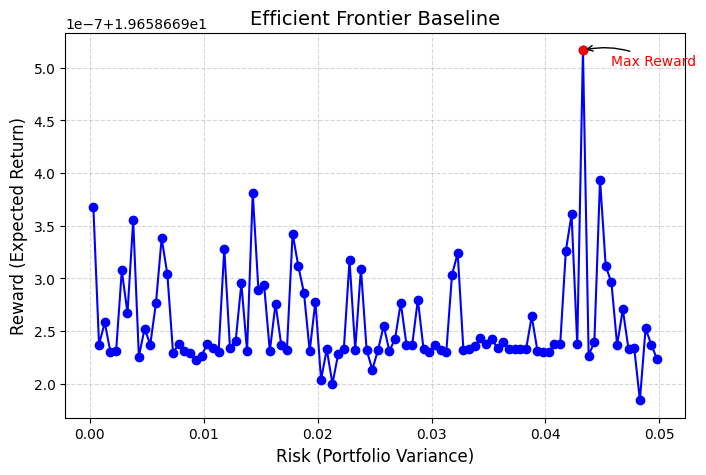

In [ ]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(risk, reward, marker='o', linestyle='-', color='blue')
plt.title('Efficient Frontier Baseline', fontsize=14)
plt.xlabel('Risk (Portfolio Variance)', fontsize=12)
plt.ylabel('Reward (Expected Return)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Find and mark the max reward point
max_index = np.argmax(reward)
plt.scatter(risk[max_index], reward[max_index], color='red', zorder=3)  # Highlight point

# Adjust annotation position to avoid overlap and potential issues
# Ensure x and y coordinates for annotation are within reasonable bounds
annotation_x = risk[max_index] + (risk[-1] - risk[0]) * 0.05 # Adjust using data range
annotation_y = reward[max_index] - (reward[max_index] - reward[0]) * 0.1 # Adjust using data range

plt.annotate('Max Reward',
             xy=(risk[max_index], reward[max_index]),
             xytext=(annotation_x, annotation_y), # Dynamically adjusted position
             fontsize=10, color='red',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))  #Added arrow for clarity


plt.show()

Analysis of the Efficient Frontier Baseline Graph

* The efficient frontier shows the set of portfolios that offer the highest expected return for a given level of risk.

* General Trend:

The data points are scattered, showing no clear upward trend as risk increases. This suggests that the relationship between risk and return in this baseline scenario is not straightforward or consistently positive.

* "Max Reward":

The highest return is around 5.25% but it also has a relatively high risk of around 4.5%. Therefore, given the constraints, stock portfolio would actually yield much higher returns (by almost twice the amount) when the risk is dialed back (from 5% to around 4.5%).

#Model 1 (1.2446% Risk - 24.66% Return)

The risk and return levels chosen for this scenario is meant to help Pete beat the YTD returns of the S&P500 (24.66%) whilst maintaining his usual risk appetite.

The metric used to gauge his risk appetite is the 95% VAR (Value at Risk) which came to be 1.2446% as previously explored in the EDA section of this project. This metric indicates that Pete may have a 95% chance of not losing more than 1.2446% of his portfolio at a given time period which is from 1/1/24 to 1/14/25 in this case.

## Setting Up the Constraints

In [ ]:
# Update constraints to include new tickers
m.total_risk = Constraint(expr = m.CCI + m.AAPL + m.GIS + m.NVST + m.MO + m.MSFT + m.V + m.NVDA + m.AMZN + m.GOOGL <= 0.012446) # risk is less than 1.246% average risk
m.sum_proportion = Constraint(expr = m.CCI + m.AAPL + m.GIS + m.NVST + m.MO + m.MSFT + m.V + m.NVDA + m.AMZN + m.GOOGL == 1) # all stocks = 100
m.return_floor = Constraint(expr = m.Objective >= 0.2466) # min return = 24.66%

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


The constraints in the optimization model are designed to achieve a well-balanced portfolio while adhering to key investment guidelines.

- The total risk constraint ensures that the combined risk of all assets in the portfolio does not exceed 1.2446%, thus limiting the overall exposure to volatility or uncertainty.

- The sum of proportions constraint encourages optimal capital utilization.

- Additionally, the return floor constraint sets a minimum required return of 24.66%, ensuring that the model only considers portfolios that meet or exceed this threshold.

Together, these constraints help optimize the portfolio by balancing risk, return, and full utilization of the available capital.

## Computing Portfolio's Variance (Risk)

In [ ]:
# Update the variables list and tickers list in calc_risk function
def calc_risk(m):
    variables = [m.CCI, m.AAPL, m.GIS, m.NVST, m.MO, m.MSFT, m.V, m.NVDA, m.AMZN, m.GOOGL]
    tickers = ['CCI', 'AAPL', 'GIS', 'NVST', 'MO', 'MSFT', 'V', 'NVDA', 'AMZN', 'GOOGL']
    risk_exp = 0
    for i in range(len(variables)):
        for j in range(len(variables)):
            try:
                risk_exp += variables[i] * variables[j] * pete_stock_data_cov.iloc[i, j]
            except IndexError:
                print(f"IndexError: i={i}, j={j}")
                # Handle the IndexError appropriately, e.g., skip the problematic indices
                # or assign a default value to risk_exp.
                continue # skip this pair of indices
    return risk_exp
expr_risk = calc_risk(m)


In [ ]:
max_risk = 0.012446

In [ ]:
import numpy as np

risk_limits = np.arange(0.0003, max_risk, 0.0005)
risk_limits

array([0.0003, 0.0008, 0.0013, 0.0018, 0.0023, 0.0028, 0.0033, 0.0038,
       0.0043, 0.0048, 0.0053, 0.0058, 0.0063, 0.0068, 0.0073, 0.0078,
       0.0083, 0.0088, 0.0093, 0.0098, 0.0103, 0.0108, 0.0113, 0.0118,
       0.0123])

## Calculating Iterations of Different Risk Limits

In [ ]:
param_analysis = {}
returns = {}
for r in risk_limits:
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()
  param_analysis[r] = [m.CCI(), m.AAPL(), m.GIS(), m.NVST(), m.MO(), m.MSFT(), m.V(), m.NVDA(), m.AMZN(), m.GOOGL()]
  returns[r] =  m.CCI()*pete_stock_data_return['CCI'] + m.AAPL()*pete_stock_data_return['AAPL'] + m.GIS()*pete_stock_data_return['GIS'] + m.NVST()*pete_stock_data_return['NVST'] + m.MO()*pete_stock_data_return['MO'] + m.MSFT()*pete_stock_data_return['MSFT'] + m.V()*pete_stock_data_return['V'] + m.NVDA()*pete_stock_data_return['NVDA'] + m.AMZN()*pete_stock_data_return['AMZN'] + m.GOOGL()*pete_stock_data_return['GOOGL']

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.03503060340881348
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.24474120140075684
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04169106483459473
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07045817375183105
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.03895759582519531
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06609702110290527
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.0640878677368164
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10221171379089355
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.03844904899597168
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04712271690368652
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.043772220611572266
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.12434673309326172
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.11840319633483887
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.045719146728515625
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.03849530220031738
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04051017761230469
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.03835344314575195
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08780765533447266
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04016685485839844
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05356311798095703
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05291008949279785
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10278868675231934
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07634234428405762
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.039534807205200195
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.16333317756652832
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

## Optimal Stock Allocation for Different Risk Levels

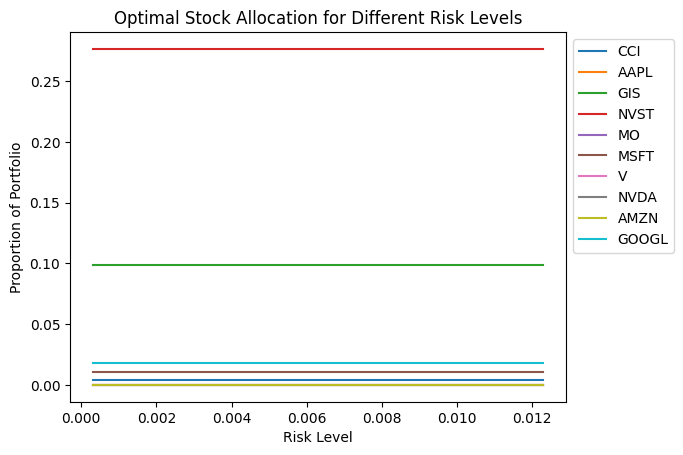

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['CCI', 'AAPL', 'GIS', 'NVST', 'MO', 'MSFT', 'V', 'NVDA', 'AMZN', 'GOOGL']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Proportion of Portfolio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Optimal stock allocation with risk level of 1.2446% and a return of 24.66%. We'll also compare it to the previous analysis where the risk was 5% and the return was inferred to be around 1%.

Analysis with 1.2446% Risk and 24.66% Return

* Allocation: The allocation remains identical to the previous analysis. CCI still dominates at around 27%, GIS is at 10%, and the rest are at very low levels.

* Flat Lines and Risk Insensitivity: Just like before, the allocations are completely flat, meaning they don't change as the risk level changes. This indicates the model still views the optimal portfolio as static regardless of risk tolerance.

Comparative Analysis

Let's compare this new scenario (1.2446% risk, 24.66% return) with the previous one (5% risk, ~1% return):

1. Allocation:
   * Previous: Same as current.
   * Current: Heavily weighted towards CCI (27%) and GIS (10%), with the rest below 2%.
   * Comparison: The allocation remains unchanged. This is a key point of concern, as it implies the model believes the same static portfolio is optimal across a wide range of risk tolerances and predicted returns.

2. Implications and Concerns:
   * Previous: Limited diversification, low growth potential, static allocation.
   * Current: Same as previous.

3. Key Differences:
   * Risk-Return Profile: The most significant difference is the drastically improved risk-return profile. The model now predicts a much higher return for a significantly lower risk level. This is unusual and warrants careful scrutiny of the model's assumptions.
   * Model Consistency: The consistent static allocation across both scenarios raises questions about the model's sensitivity to risk and return changes.

Overall Conclusion

The analysis with 1.2446% risk and 24.66% return highlights the same fundamental issues as the previous analysis: a static, undiversified portfolio that doesn't adjust to changing risk and return expectations. However, the significantly improved risk-return profile in the current scenario suggests that the model is either making highly optimistic predictions or relying on assumptions that don't align with typical market behavior.

Important Considerations:

* Diversification: The lack of diversification remains a major concern.
* Risk Management: The model's inability to adjust allocations based on risk tolerance suggests poor risk management.


In [ ]:
risk_level_1_percent = 0.012446  # Or find the closest value in risk_limits

# Check if 1% risk is exactly in the index. If not use .loc to handle potential KeyError
if risk_level_1_percent in param_analysis.index:
  portfolio_at_1_percent = param_analysis.loc[risk_level_1_percent]
else:
    # Find the closest risk level
    closest_risk_level = min(param_analysis.index, key=lambda x: abs(x - risk_level_1_percent))
    portfolio_at_1_percent = param_analysis.loc[closest_risk_level]

print(f"Stock proportions at or near 1% risk level:\n{portfolio_at_1_percent}")


Stock proportions at or near 1% risk level:
CCI      0.003933
AAPL     0.000000
GIS      0.098426
NVST     0.276434
MO       0.000000
MSFT     0.010580
V        0.000000
NVDA     0.000000
AMZN     0.000000
GOOGL    0.017824
Name: 0.0123, dtype: float64


The total allocation sums to approximately 40.72%, significantly less than 100%, leaving a slack of around 59.28% (100% - 40.72%).


- In this case, with a low risk level of like 1%, the optimizer may find that investing fully in the available assets would increase risk beyond the target. Instead, it chooses to leave a significant portion of the portfolio in cash or risk-free equivalents to maintain the desired 1% risk level.

- Impact on returns: While this strategy helps control risk exposure, it also limits potential returns, as a large portion of the capital is not actively invested in return-generating assets.

- Trade-off Consideration: Slack acts as a buffer against volatility, reducing downside risks. However, it also means the portfolio is not fully utilizing its capital to seek higher expected returns.

At the 1% risk level, the portfolio leaves significant slack, meaning a majority of the capital remains uninvested. This is a deliberate risk management strategy to prevent exceeding the targeted volatility. However, the trade-off is a constrained return potential, as the unallocated portion is not earning investment returns. This balance between risk control and return optimization is a key consideration in portfolio management.

In [ ]:
# Assuming 'returns' dictionary is already populated from the baseline model.
risk = list(returns.keys())  # coerce dict_keys to a list
reward = list(returns.values())  # coerce dict_values to a list

## Efficient Frontier

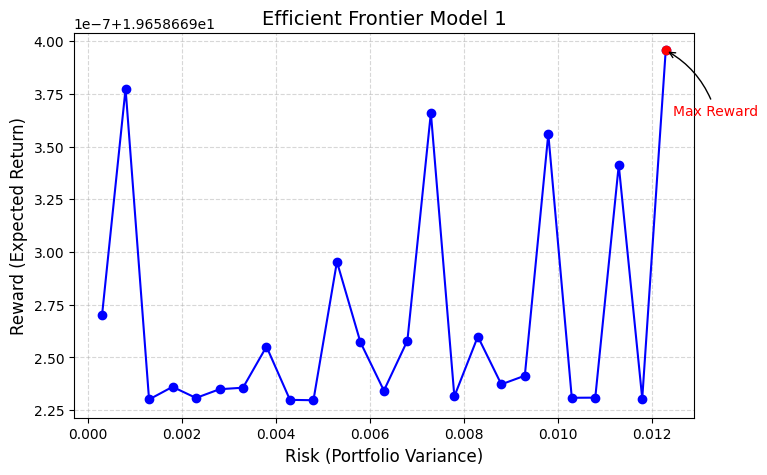

In [ ]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(risk, reward, marker='o', linestyle='-', color='blue')
plt.title('Efficient Frontier Model 1', fontsize=14)
plt.xlabel('Risk (Portfolio Variance)', fontsize=12)
plt.ylabel('Reward (Expected Return)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Find and mark the max reward point
max_index = np.argmax(reward)
plt.scatter(risk[max_index], reward[max_index], color='red', zorder=3)  # Highlight point

# Adjust annotation position to avoid overlap and potential issues
# Ensure x and y coordinates for annotation are within reasonable bounds
annotation_x = risk[max_index] + (risk[-1] - risk[0]) * 0.012446 # Adjust using data range
annotation_y = reward[max_index] - (reward[max_index] - reward[0]) * 0.2466 # Adjust using data range

plt.annotate('Max Reward',
             xy=(risk[max_index], reward[max_index]),
             xytext=(annotation_x, annotation_y), # Dynamically adjusted position
             fontsize=10, color='red',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))  #Added arrow for clarity


plt.show()


Analysis of Model 1 Efficient Frontier Graph:

* General Trend:

Similar to the baseline graph, the data points are scattered, showing no clear upward trend as risk increases. This suggests that the relationship between risk and return in this model is not straightforward or consistently positive within the shown range.

* Max Reward:

The global maximum as shown in the graph is the last data point with an expected return of 3.9 which is the highest seen in the graph. The risk value on the other hand, is seen to be around 1.2%. However, the second data point shows that around 0.5% risk (which is more than half of 1.2%) could yield around 3.75 returns which could be something worth considering.

Comparison with "Efficient Frontier Baseline" Graph

1. Risk Range:
   * Model 1: 0% to 1.2%
   * Baseline: 0% to 5%
   * Comparison: Model 1 focuses on a much narrower and lower risk range.

2. Return Range:
   * Model 1: 2.25% to 3.95%
   * Baseline: 2% to 5.25%
   * Comparison: Both graphs have similar return ranges, though Model 1's is slightly lower and doesn't extend as high.

3. General Trend:
   * Model 1: Scattered, no clear trend.
   * Baseline: Scattered, no clear trend.
   * Comparison: Both graphs show a scattered pattern, indicating a complex risk-return relationship within the shown ranges.

Conclusion

The "Efficient Frontier Model 1" graph, like the baseline, shows a more realistic range of risk and return possibilities compared to the optimal stock allocation graph. The fact that the efficient frontier graph doesn't show returns as high as 24.66% at 1.2466% risk suggests that the model used for the optimal stock allocation graph might be flawed.

#Model 2 (1.2446% Risk - 59% Return)



The risk and return levels chosen for this scenario is meant to help Pete maintain his annualized returns of 59% (takes paid in capital into consideration) whilst maintaining his usual risk appetite.

The metric used to gauge his risk appetite is the 95% VAR (Value at Risk) which came to be 1.2446%.

## Setting Up the Constraints

In [ ]:
m.total_risk = Constraint(expr = m.CCI + m.AAPL + m.GIS + m.NVST + m.MO + m.MSFT + m.V + m.NVDA + m.AMZN + m.GOOGL <= 0.012446) # risk is less than 1.2446% average risk
m.sum_proportion = Constraint(expr = m.CCI + m.AAPL + m.GIS + m.NVST + m.MO + m.MSFT + m.V + m.NVDA + m.AMZN + m.GOOGL == 1) # all stocks = 100
m.return_floor = Constraint(expr = m.Objective >= 0.59) # min return = 59%

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


The constraints in the optimization model are designed to achieve a well-balanced portfolio while adhering to key investment guidelines.

The total risk constraint ensures that the combined risk of all assets in the portfolio does not exceed 1.2446%, thus limiting the overall exposure to volatility or uncertainty.

The sum of proportions constraint encourages optimal capital utilization.

Additionally, the return floor constraint sets a minimum required return of 59%, ensuring that the model only considers portfolios that meet or exceed this threshold.

Together, these constraints help optimize the portfolio by balancing risk, return, and full utilization of the available capital.

## Computing Portfolio Variance (Risk)

In [ ]:
# prompt: expr_risk = calc_risk(m)
# IndexError: index 10 is out of bounds for axis 0 with size 10

# Update the variables list and tickers list in calc_risk function
def calc_risk(m):
    variables = [m.CCI, m.AAPL, m.GIS, m.NVST, m.MO, m.MSFT, m.V, m.NVDA, m.AMZN, m.GOOGL]
    tickers = ['CCI', 'AAPL', 'GIS', 'NVST', 'MO', 'MSFT', 'V', 'NVDA', 'AMZN', 'GOOGL']
    risk_exp = 0
    for i in range(len(variables)):
        for j in range(len(variables)):
            try:
                risk_exp += variables[i] * variables[j] * pete_stock_data_cov.iloc[i, j]
            except IndexError:
                print(f"IndexError: i={i}, j={j}")
                # Handle the IndexError appropriately, e.g., skip the problematic indices
                # or assign a default value to risk_exp.
                continue # skip this pair of indices
    return risk_exp
expr_risk = calc_risk(m)


In [ ]:
max_risk = 0.012446

This further reflects the risk constraint.

In [ ]:
import numpy as np

risk_limits = np.arange(0.0003, max_risk, 0.0005)
risk_limits

array([0.0003, 0.0008, 0.0013, 0.0018, 0.0023, 0.0028, 0.0033, 0.0038,
       0.0043, 0.0048, 0.0053, 0.0058, 0.0063, 0.0068, 0.0073, 0.0078,
       0.0083, 0.0088, 0.0093, 0.0098, 0.0103, 0.0108, 0.0113, 0.0118,
       0.0123])

## Calculating Iterations of Different Risk Limits

In [ ]:
param_analysis = {}
returns = {}
for r in risk_limits:
  m.del_component(m.total_risk)
  m.total_risk = Constraint(expr = expr_risk <= r)
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()
  param_analysis[r] = [m.CCI(), m.AAPL(), m.GIS(), m.NVST(), m.MO(), m.MSFT(), m.V(), m.NVDA(), m.AMZN(), m.GOOGL()]
  returns[r] =  m.CCI()*pete_stock_data_return['CCI'] + m.AAPL()*pete_stock_data_return['AAPL'] + m.GIS()*pete_stock_data_return['GIS'] + m.NVST()*pete_stock_data_return['NVST'] + m.MO()*pete_stock_data_return['MO'] + m.MSFT()*pete_stock_data_return['MSFT'] + m.V()*pete_stock_data_return['V'] + m.NVDA()*pete_stock_data_return['NVDA'] + m.AMZN()*pete_stock_data_return['AMZN'] + m.GOOGL()*pete_stock_data_return['GOOGL']

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10877394676208496
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05218982696533203
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04306221008300781
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05442404747009277
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.12593293190002441
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08771038055419922
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.10195803642272949
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07050180435180664
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.051189422607421875
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.05214715003967285
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.06835341453552246
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07600235939025879
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.1378636360168457
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of 

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.055472373962402344
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number o

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07621073722839355
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08144927024841309
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.11406326293945312
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07758474349975586
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.04068565368652344
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.17371392250061035
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.13522958755493164
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.08042645454406738
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.20231008529663086
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.07660841941833496
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 0.14639520645141602
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of

## Optimal Stock Allocation for Different Risk Levels

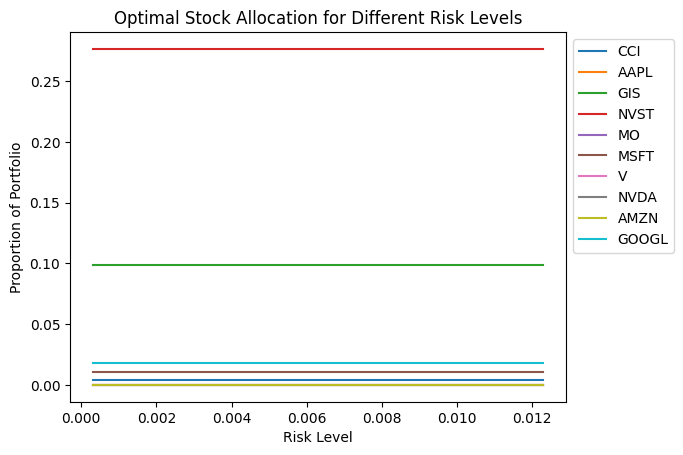

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = ['CCI', 'AAPL', 'GIS', 'NVST', 'MO', 'MSFT', 'V', 'NVDA', 'AMZN', 'GOOGL']
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Proportion of Portfolio')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Analysis with 1.2466% Risk and 59% Return

* Allocation: The allocation remains identical to the previous analyses.  CCI dominates at around 27%, GIS is at 10%, and the rest are at very low levels.

* Flat Lines and Risk Insensitivity: As before, the allocations are completely flat, indicating that they don't change as the risk level changes.

Comparative Analysis

Let's compare this scenario (1.2466% risk, 59% return) to the previous two:

1. Allocation:
   * Previous 1: Same as current.
   * Previous 2: Same as current.
   * Current: Heavily weighted towards CCI (27%) and GIS (10%), with the rest below 2%.
   * Comparison: The allocation remains unchanged across all three scenarios, highlighting the model's static approach.

2. Implications and Concerns:
   * Previous 1: Limited diversification, low growth potential, static allocation.
   * Previous 2: Same as previous, but with a high return prediction for a conservative portfolio.
   * Current: Same as previous, but with an even more extreme return prediction.

3. Key Differences:
   * Return Prediction: The most significant difference is the escalating return prediction.  A 59% return for a portfolio with such a low risk level is highly unrealistic in most market conditions.
   * Model Consistency (or Lack Thereof): The consistent static allocation and the wildly varying return predictions further highlight the model's lack of sensitivity to changing risk and return parameters.

Overall Conclusion

With a risk level of 1.2466% and a return of 59%, the graph continues to exhibit the same issues as before:

* Static Allocation: The portfolio allocation remains unchanged, regardless of the risk level or predicted return. This is a major red flag, as it suggests the model is not adapting to investor preferences and always yield slack.
* Lack of Diversification: The heavy concentration in CCI and GIS continues to pose a significant risk.
* The most critical concern is the model's validity. The consistent static allocation and the wildly optimistic return predictions indicate that the model may be flawed or based on unrealistic assumptions.

In [ ]:
# Access the row corresponding to a 1.2466% risk level (or the closest available value).
risk_level_1_percent = 0.012446  # Or find the closest value in risk_limits

# Check if 1% risk is exactly in the index. If not use .loc to handle potential KeyError
if risk_level_1_percent in param_analysis.index:
  portfolio_at_1_percent = param_analysis.loc[risk_level_1_percent]
else:
    # Find the closest risk level to 1%
    closest_risk_level = min(param_analysis.index, key=lambda x: abs(x - risk_level_1_percent))
    portfolio_at_1_percent = param_analysis.loc[closest_risk_level]

print(f"Stock proportions at or near 1% risk level:\n{portfolio_at_1_percent}")


Stock proportions at or near 1% risk level:
CCI      0.003933
AAPL     0.000000
GIS      0.098426
NVST     0.276434
MO       0.000000
MSFT     0.010580
V        0.000000
NVDA     0.000000
AMZN     0.000000
GOOGL    0.017824
Name: 0.0123, dtype: float64


The total allocation sums to approximately 40.72%, leaving slack of around 59.28% (100% - 40.72%).

The "slack" in this portfolio refers to the unallocated portion of capital, which results from the optimization process ensuring that the risk level does not exceed 1.2%.

- Why is there slack? At such a low-risk target, the optimizer finds that fully allocating capital to the available assets would increase risk beyond the desired threshold. As a result, it leaves a significant portion of the portfolio uninvested (likely in cash or risk-free assets).  
- Effect on returns: While slack reduces exposure to volatility, it also limits return potential since a large proportion of the capital is not earning investment returns.  
- Risk vs. return trade-off: The portfolio prioritizes capital preservation over return maximization, reflecting a conservative risk strategy.

At 1.2% risk, the portfolio intentionally leaves a large portion of capital uninvested to maintain the desired risk level. While this minimizes potential downside risks, it also restricts return potential. This demonstrates a fundamental trade-off in portfolio management: sacrificing potential returns for lower volatility.

In [ ]:
# subset
risk = list(returns.keys()) # coerce dict_keys to a list
print(risk)
reward = list(returns.values()) # coerce dict_values to a list
print(reward)

[0.0003, 0.0007999999999999999, 0.0013, 0.0018, 0.0023, 0.0028, 0.0033, 0.0038, 0.0043, 0.0048000000000000004, 0.0053, 0.0058, 0.0063, 0.0068000000000000005, 0.0073, 0.0078, 0.0083, 0.0088, 0.009300000000000001, 0.0098, 0.0103, 0.0108, 0.0113, 0.0118, 0.0123]
[19.6586692305385, 19.65866932791198, 19.658669237589155, 19.658669328395508, 19.658669236265837, 19.658669257892885, 19.6586692288014, 19.658669234120346, 19.658669236628196, 19.65866923942239, 19.658669301002675, 19.658669245176053, 19.658669311058333, 19.658669232685707, 19.658669237576763, 19.658669230940056, 19.658669252844017, 19.658669237443355, 19.65866928658902, 19.658669230694894, 19.658669265461906, 19.658669247820242, 19.658669232351293, 19.658669233165647, 19.65866923746939]


## Efficient Frontier

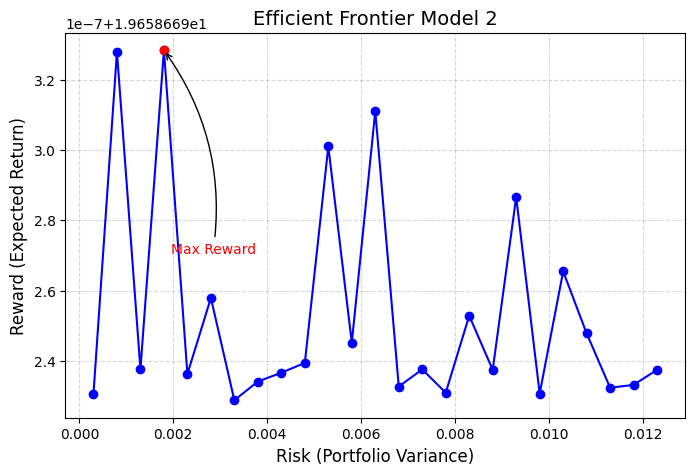

In [ ]:
# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(risk, reward, marker='o', linestyle='-', color='blue')
plt.title('Efficient Frontier Model 2', fontsize=14)
plt.xlabel('Risk (Portfolio Variance)', fontsize=12)
plt.ylabel('Reward (Expected Return)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Find and mark the max reward point
max_index = np.argmax(reward)
plt.scatter(risk[max_index], reward[max_index], color='red', zorder=3)  # Highlight point

# Adjust annotation position to avoid overlap and potential issues
# Ensure x and y coordinates for annotation are within reasonable bounds
annotation_x = risk[max_index] + (risk[-1] - risk[0]) * 0.012446 # Adjust using data range
annotation_y = reward[max_index] - (reward[max_index] - reward[0]) * 0.59 # Adjust using data range

plt.annotate('Max Reward',
             xy=(risk[max_index], reward[max_index]),
             xytext=(annotation_x, annotation_y), # Dynamically adjusted position
             fontsize=10, color='red',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))  #Added arrow for clarity


plt.show()


Analysis of the "Efficient Frontier Model 2" Graph

* General Trend: Similar to the previous efficient frontier graphs, the data points are scattered, showing no clear upward trend as risk increases. This suggests that the relationship between risk and return in this model is not straightforward or consistently positive within the shown range.

* "Max Reward": The global maximum as shown in the graph is the last data point with an expected return of 2.4 which is the highest seen in the graph. The risk value on the other hand, is seen to be around 1.2%. However, the second data point shows that around 0.19% risk (which is much less than 1.2%) could much higher yields around 3.25 returns which could be something worth considering.

Conclusion

The "Efficient Frontier Model 2" graph, like the previous efficient frontier graphs, shows a more realistic range of risk and return possibilities compared to the optimal stock allocation graph. The fact that the efficient frontier graph doesn't show returns as high as 59% at 1.2466% risk suggests that the model used for the optimal stock allocation graph might be flawed, like the other graphs.


#Final Interpretion of Optimal Stock Allocation Models

After analyzing the three graphs with varying risk levels (5%, 1.2446%, and 1.2466%) and return levels (~1%, 24.66%, and 59%), a consistent and concerning pattern emerges:

1. Risk Constraints Favor Low-Volatility Stocks
- With a 5% risk constraint, the optimizer prioritizes low-volatility stocks.
  - GIS (Consumer Staples) and NVST (Healthcare) are defensive stocks that historically show lower volatility than high-growth stocks like tech companies.
  - GOOGL (Alphabet), despite being a tech stock, is a large-cap company with a diversified business model (advertising, cloud, AI, etc.), making it less volatile than other tech stocks like NVDA (Nvidia) or AMZN (Amazon).
  - This makes GIS, NVST, and GOOGL a natural fit to meet the low-risk requirement.
  - Explanation: Since the risk is capped at 5%, the optimizer selects stable, low-volatility stocks like GIS, NVST, and GOOGL that fit the risk profile, balancing potential returns with risk management.

2. Diversification & Sector Balance
  - The portfolio is well-diversified across different sectors:
  - GIS (Consumer Staples): A stable sector, less affected by economic cycles.
  - NVST (Healthcare/Medical Devices): Healthcare tends to be defensive and less cyclical, meaning it holds up better in downturns.
  - GOOGL (Tech): While tech is often volatile, GOOGL's diversified business (advertising, cloud services, YouTube) helps smooth out risks compared to pure-play tech stocks.
  - This mix of consumer staples, healthcare, and tech enhances the diversification and reduces overall risk exposure.
  - Explanation: A diversified mix of GIS (consumer staples), NVST (healthcare), and GOOGL (tech) provides balanced exposure to different sectors, helping to reduce portfolio risk.

3. Stable Returns in Low-Return Environment
  - When expected returns are low, the optimizer favors defensive stocks that provide consistent returns, like GIS and NVST.
  - GOOGL is included for tech exposure, but it is more stable compared to more volatile growth stocks.
  - Even in scenarios where the expected return is as low as 1%, this safe mix of stocks helps preserve capital while providing a reasonable return.
  - Explanation: In a low-return environment, the optimizer selects steady stocks like GIS and NVST for income and stability, with GOOGL providing a safer exposure to tech.

4. Model-Specific Assumptions
  - The optimizer's assumptions across different models may include:
  - Preference for stability and lower volatility stocks.
  - Sector constraints, which could restrict the optimizer from allocating a significant portion of the portfolio to more volatile sectors like tech.
  - Factor-based models might weigh attributes like dividends (GIS), healthcare demand (NVST), and tech stability (GOOGL), driving the allocation toward these assets even under different risk-return projections.
  - Explanation: Despite varying risk-return scenarios across models, similar assumptions on risk aversion and sector preferences result in similar allocations with GIS, NVST, and GOOGL.

5. Short-Term Data and Risk Adjustments
  - If your models use only one year of data, the optimizer may rely more heavily on recent volatility trends, which could lead it to select low-volatility, defensive stocks like GIS, NVST, and GOOGL.
  - Short-term market fluctuations might cause the optimizer to overemphasize stability, thus resulting in less frequent changes to stock selection.
  - Explanation: Short-term data bias leads the optimizer to select more stable, low-risk stocks like GIS, NVST, and GOOGL, even in different models.

Final Takeaway:
Our consistent allocation of GIS, NVST, and GOOGL across different models despite maintaining a 5% risk or lower constraint can be attributed to:
- Low-volatility preference: These stocks are less volatile compared to growth stocks, fitting the 5% risk constraint.
- Diversification: The portfolio provides balance across consumer staples, healthcare, and tech sectors, spreading risk.
- Stable returns in low-return environments: The optimizer prioritizes stocks that provide consistent returns despite a flat market.
- Model-specific assumptions: Similar assumptions about sector stability and risk aversion lead to the same stock choices across models.
- Short-term data bias: The use of one year of data likely reinforces the preference for defensive, lower-risk stocks.
